In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
## Reading in data
df = pd.read_csv('globalterrorismdb_0616dist.csv', encoding='latin1', low_memory=False)
print(df.shape)
df[:5]

(156772, 137)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### Initial EDA

In [4]:
df.isnull().sum().sort_values(ascending=False)

gsubname3           156766
weapsubtype4        156701
weaptype4           156698
claimmode3          156696
gsubname2           156651
claim3              156614
guncertain3         156612
ingroup3            156608
gname3              156608
divert              156483
attacktype3         156460
ransompaidus        156370
claimmode2          156367
ransomamtus         156361
ransomnote          156351
ransompaid          156149
corp3               155990
targsubtype3        155912
natlty3             155868
target3             155841
targtype3           155840
claim2              155677
guncertain2         155610
ransomamt           155577
ingroup2            155553
gname2              155553
weapsubtype3        155466
weaptype3           155340
kidhijcountry       153482
nhours              153470
                     ...  
iyear                    0
success                  0
suicide                  0
attacktype1              0
weaptype1_txt            0
targsubtype3_txt         0
i

In [5]:
# number of attack type 2/3 null observations
df[['attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt']].isnull().sum()

attacktype2        151806
attacktype2_txt         0
attacktype3        156460
attacktype3_txt         0
dtype: int64

#### Attack Types and Corresponding Number within Dataset
- 1 = Assasination
- 2 = Armed Assault
- 3 = Bombing/Explosion
- 4 = Hijacking
- 5 = Hostage Taking (BARRICADE INCIDENT)
- 6 = Hostage Taking (Kidnapping)
- 7 = Facility/Infastructure attack
- 8 = Unarmed assault
- 9 = Unknown

In [6]:
# number of each type of primary attack 
print(df.attacktype1_txt.value_counts())

Bombing/Explosion                      75963
Armed Assault                          37554
Assassination                          17582
Hostage Taking (Kidnapping)             9115
Facility/Infrastructure Attack          8849
Unknown                                 5490
Hostage Taking (Barricade Incident)      835
Unarmed Assault                          828
Hijacking                                556
Name: attacktype1_txt, dtype: int64


In [7]:
# forming dataframe of bombings only as primary attack
df_bombings = df[df.attacktype1 == 3]
df_bombings.shape

(75963, 137)

In [8]:
# already saved, commented out as to not run again
# df_bombings.to_csv('bombings.csv')

In [9]:
# sorting out by most bombings per year
df_bombings.iyear.value_counts().sort_values(ascending=False)

2014    8759
2015    7615
2013    6669
2012    5080
2008    2642
2011    2587
2009    2565
2010    2507
1991    1988
2007    1865
1989    1797
1984    1775
1992    1738
1990    1731
1988    1650
1986    1506
2006    1502
1985    1482
1987    1476
1983    1246
1996    1217
1994    1153
1982    1125
1997    1123
1981    1082
2005    1064
1979    1057
1980     997
2000     904
2001     802
1995     791
2002     721
2003     678
2004     655
1999     652
1978     644
1977     635
1998     504
1976     419
1975     370
1970     333
1974     284
1971     238
1972     186
1973     149
Name: iyear, dtype: int64

In [10]:
# df['Event_Date'] = str(df.iyear)+"-"+str(df.imonth)+"-"+str(df.iday)
# df.head()

In [11]:
# Group name counts of main perpetrators for all attacks
df.gname.value_counts().sort_values(ascending=False)

Unknown                                                          71922
Taliban                                                           5502
Shining Path (SL)                                                 4548
Farabundo Marti National Liberation Front (FMLN)                  3351
Islamic State of Iraq and the Levant (ISIL)                       2833
Irish Republican Army (IRA)                                       2670
Revolutionary Armed Forces of Colombia (FARC)                     2474
New People's Army (NPA)                                           2241
Al-Shabaab                                                        2127
Basque Fatherland and Freedom (ETA)                               2024
Boko Haram                                                        1839
Kurdistan Workers' Party (PKK)                                    1782
Communist Party of India - Maoist (CPI-Maoist)                    1666
Liberation Tigers of Tamil Eelam (LTTE)                           1606
Nation

In [12]:
# looking at all ISIS or ISIL attacks
df[df['gname'].str.contains('ISIL' or 'ISIS')] #or df['gname'].str.contains('ISIL')]

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
116002,201304180002,2013,4,18,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this incident conflict ac...,"""Suicide attack kills 26 in Iraq,"" New Straits...","""Suicide bomber kills at least 27 in Baghdad c...","""Bombing kills 32 at Baghdad cafe ahead of vot...",START Primary Collection,-9,-9,0,-9,NaN
116074,201304200018,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""Poll centre attacks mar Iraq provincial vote,...","""Bombings mar start to milestone Iraq election...",START Primary Collection,-9,-9,0,-9,"201304200019, 201304200020"
116075,201304200019,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,-9,-9,0,-9,"201304200018, 201304200020"
116076,201304200020,2013,4,20,NaN,0,NaN,95,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,-9,-9,0,-9,"201304200018, 201304200019"
116819,201305110007,2013,5,11,NaN,0,NaN,209,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey twin bombings death toll rises to 48,""...",START Primary Collection,1,1,1,1,201305110008
116820,201305110008,2013,5,11,NaN,0,NaN,209,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey opens trial over deadly ReyhanlÄ± bomb...",START Primary Collection,1,1,1,1,201305110007
117009,201305160006,2013,5,16,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""3 people killed in car bombing in Baghdad Shi...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,-9,-9,0,-9,"201305160007, 201305160008"
117010,201305160007,2013,5,16,NaN,0,NaN,95,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,-9,-9,0,-9,"201305160006, 201305160008"
117011,201305160008,2013,5,16,NaN,0,NaN,95,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,-9,-9,0,-9,"201305160006, 201305160007"
117012,201305160009,2013,5,16,NaN,0,NaN,95,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""Wave of bombings, shootings kills 11 in Iraq,...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,-9,-9,0,-9,NaN


In [13]:
df_bombings.iyear.value_counts()

2014    8759
2015    7615
2013    6669
2012    5080
2008    2642
2011    2587
2009    2565
2010    2507
1991    1988
2007    1865
1989    1797
1984    1775
1992    1738
1990    1731
1988    1650
1986    1506
2006    1502
1985    1482
1987    1476
1983    1246
1996    1217
1994    1153
1982    1125
1997    1123
1981    1082
2005    1064
1979    1057
1980     997
2000     904
2001     802
1995     791
2002     721
2003     678
2004     655
1999     652
1978     644
1977     635
1998     504
1976     419
1975     370
1970     333
1974     284
1971     238
1972     186
1973     149
Name: iyear, dtype: int64

In [14]:
df.region.value_counts()

10    40422
6     37841
3     18628
8     16020
11    13434
5     10360
2     10337
9      4892
1      3268
4       786
7       538
12      246
Name: region, dtype: int64

In [15]:
# forming dataframe of middle east attacks only
df_middle_east = df[df.region == 10]
print(df_middle_east.shape)
df_middle_east[:5]

(40422, 137)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
95,197002280001,1970,2,28,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN


In [16]:
df_middle_east.gname.value_counts()

Unknown                                                 24664
Islamic State of Iraq and the Levant (ISIL)              2824
Kurdistan Workers' Party (PKK)                           1616
Palestinians                                             1104
Al-Qaida in the Arabian Peninsula (AQAP)                  890
Al-Qaida in Iraq                                          634
Huthi Extremists                                          554
Hamas (Islamic Resistance Movement)                       384
Hezbollah                                                 374
Algerian Islamic Extremists                               373
Muslim Fundamentalists                                    366
Al-Gama'at al-Islamiyya (IG)                              257
Dev Sol                                                   236
Palestinian Extremists                                    226
Armed Islamic Group (GIA)                                 226
Salafist Group for Preaching and Fighting (GSPC)          212
Al-Nusra

In [17]:
# middle east bombings only
df_mideast_bombings = df_middle_east[df_middle_east.attacktype1 == 3]
df_mideast_bombings.shape

(24053, 137)

In [18]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,NaN,PGIS,0,0,1,1,NaN


### Part One: Bayesian Inference

In [19]:
# fingind average annual bombings in mid east prior to 2003
pre_03_mean = df_mideast_bombings[df_mideast_bombings.iyear <= 2003].iyear.value_counts().values.mean()
print("Mean annual bombings in middle east prior to 2003:", round(pre_03_mean, 3))

# fingind average annual bombings in mid east after to 2003
post_03_mean = df_mideast_bombings[df_mideast_bombings.iyear > 2003].iyear.value_counts().values.mean()
print("Mean annual bombings in middle east post 2003:", round(post_03_mean, 3))

Mean annual bombings in middle east prior to 2003: 138.727
Mean annual bombings in middle east post 2003: 1622.917


In [20]:
pre2003_mideast_bombings = df_mideast_bombings[df_mideast_bombings.iyear <= 2003].iyear.value_counts().values
post2003_mideast_bombings = df_mideast_bombings[df_mideast_bombings.iyear > 2003].iyear.value_counts().values

In [21]:
# Establishing a prior based on the mean & std dev of number of bombings per year, regardless of region or time period
prior_mean = df_bombings.iyear.value_counts().values.mean()
prior_std = df_bombings.iyear.value_counts().values.std()

print('Prior mean:', prior_mean)
print('Prior std dev:', prior_std)

Prior mean: 1688.0666666666666
Prior std dev: 1835.806445861509


(array([18., 18.,  5.,  0.,  0.,  1.,  0.,  1.,  1.,  1.]),
 array([ 149., 1010., 1871., 2732., 3593., 4454., 5315., 6176., 7037.,
        7898., 8759.]),
 <a list of 10 Patch objects>)

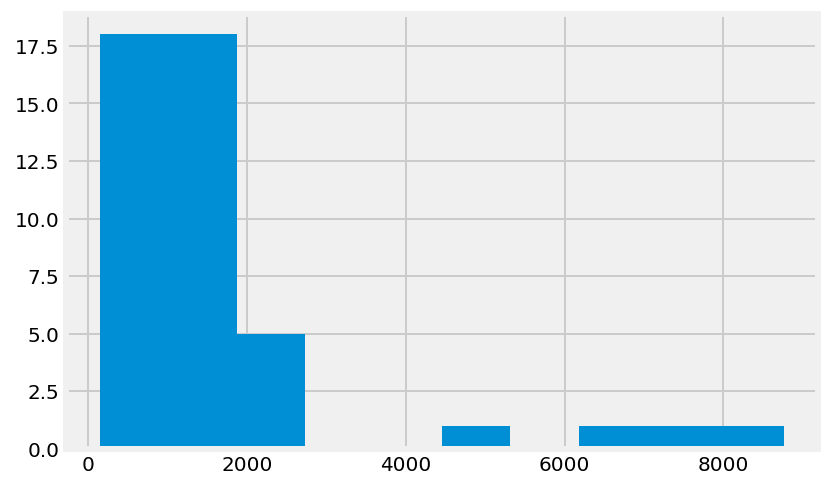

In [22]:
plt.hist(df_bombings.iyear.value_counts().values)

In [23]:
# Setting up a normal distribution for the mean of annual bombings over the course of the entire time period. 
# This assures the priors are both the same, and we will be able to conclude later if the data had an affect 
with pm.Model() as model:
    
    before2003_mean = pm.Normal('Before2003_Mean', prior_mean, sd=prior_std)
    post2003_mean = pm.Normal('Post2003_Mean', prior_mean, sd=prior_std)

In [24]:
# Setting up a normal distribution for the std. deviation of bombings/year
prior_std_lower = 50.0
prior_std_upper = 2500.00

with model:
    
    before2003_std = pm.Uniform('Before2003_std', lower=prior_std_lower, upper=prior_std_upper)
    post2003_std = pm.Uniform('Post2003_std', lower=prior_std_lower, upper=prior_std_upper)


In [25]:
# Constructing the posterior distributions for each group after given the data
with model:
    
    before2003 = pm.Normal('Before2003', mu=before2003_mean, sd=before2003_std, observed=pre2003_mideast_bombings)
    post2003 = pm.Normal('Post2003', mu=post2003_mean, sd=post2003_std, observed=post2003_mideast_bombings)

In [26]:
# Setting up a distribution for the difference of means/diff of stds between the two populations
# Also setting up a distribution for the effect size. An effect size of 0 indicates no difference btw the two
# These distributions wil help us learn more about given parameters
with model:
    
    diff_of_means = pm.Deterministic('difference of means', post2003_mean - before2003_mean)
    diff_of_stds = pm.Deterministic('difference of stds', post2003_std - before2003_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((before2003_std**2 + post2003_std**2) / 2))
    


### ***Fitting the Model with MCMC***

In [27]:
# Starting the process of MCMC estimation of posteriors(constructing arbitrary posterior distributions given our data and priors)
t0 = time.time()
with model:
    trace = pm.sample(2500) # Trace is a collection of all data points gathered by the MCMC chain
t1 = time.time()

print(t1 - t0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Post2003_std, Before2003_std, Post2003_Mean, Before2003_Mean]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1137.77draws/s]
The acceptance probability does not match the target. It is 0.9108611851249526, but should be close to 0.8. Try to increase the number of tuning steps.


8.388925790786743


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c36f50b70>,
      dtype=object)

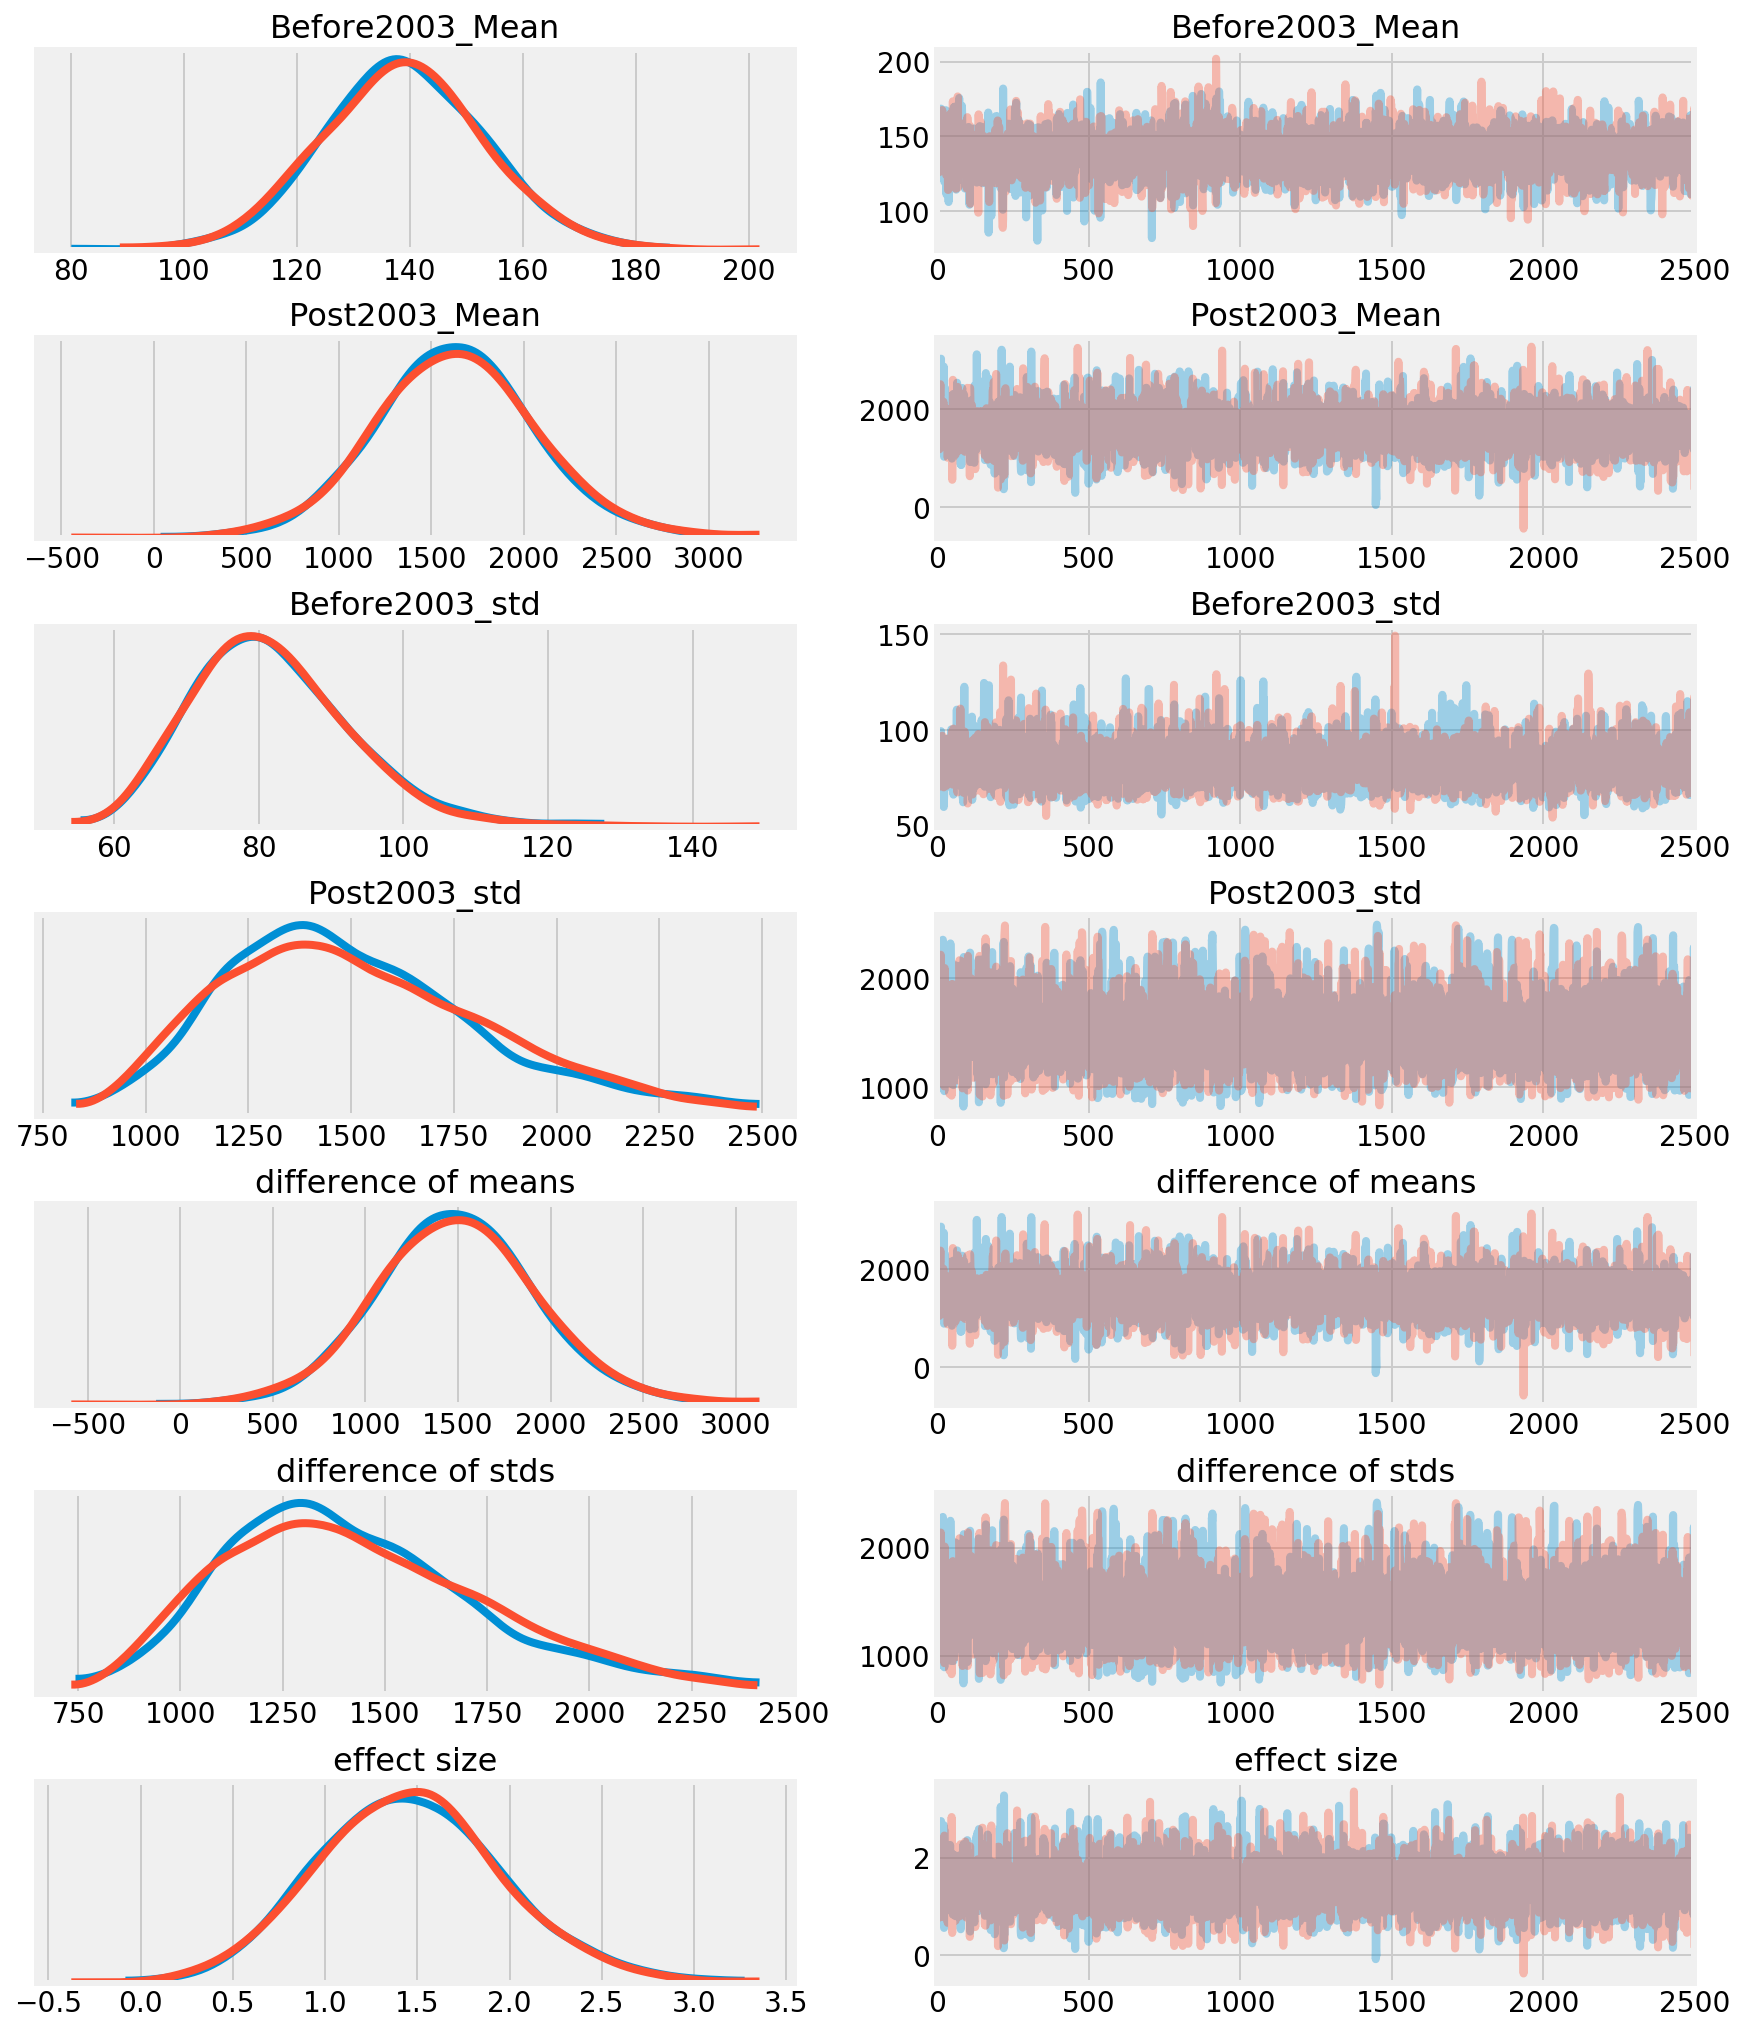

In [28]:
# Plotting the posteriors and their distributions
pm.traceplot(trace)

In [29]:
t0 = time.time()
with model:
    trace = pm.sample(25000)
t1 = time.time()

print(t1 - t0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Post2003_std, Before2003_std, Post2003_Mean, Before2003_Mean]
Sampling 2 chains: 100%|██████████| 51000/51000 [00:31<00:00, 1625.71draws/s]
The acceptance probability does not match the target. It is 0.8925143808510894, but should be close to 0.8. Try to increase the number of tuning steps.


32.901034116744995


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28c399b0>,
      dtype=object)

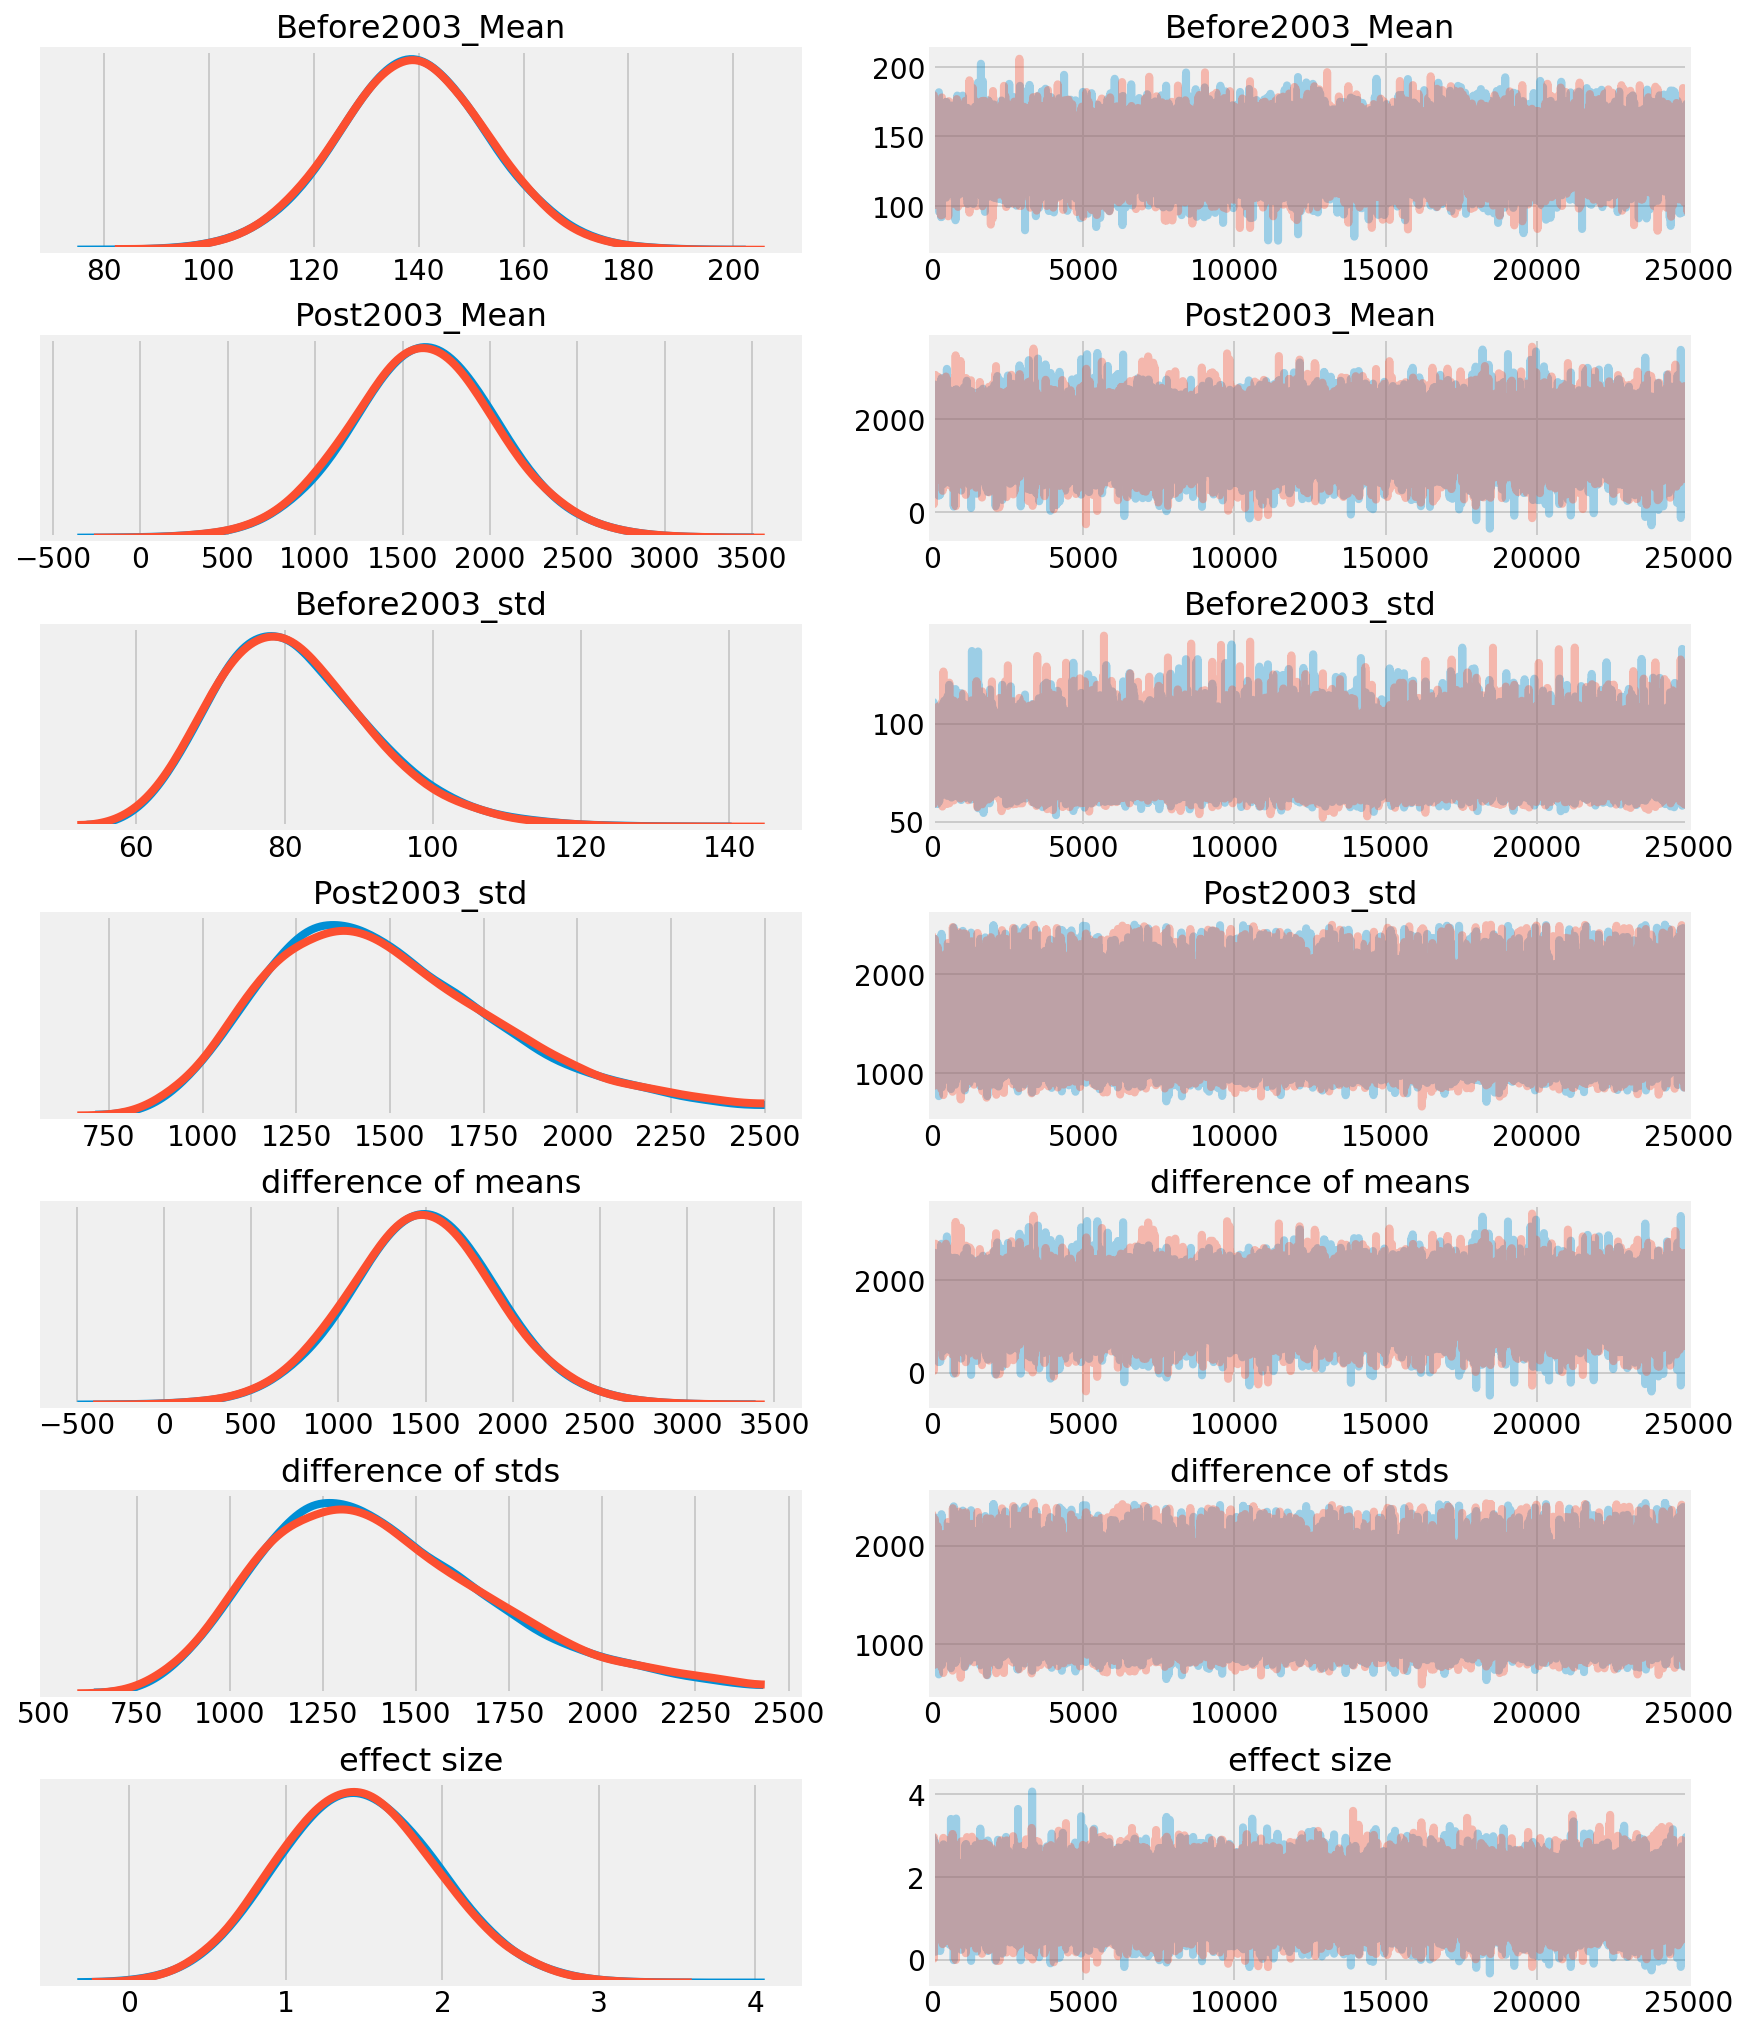

In [30]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c29c0d9b0>,
      dtype=object)

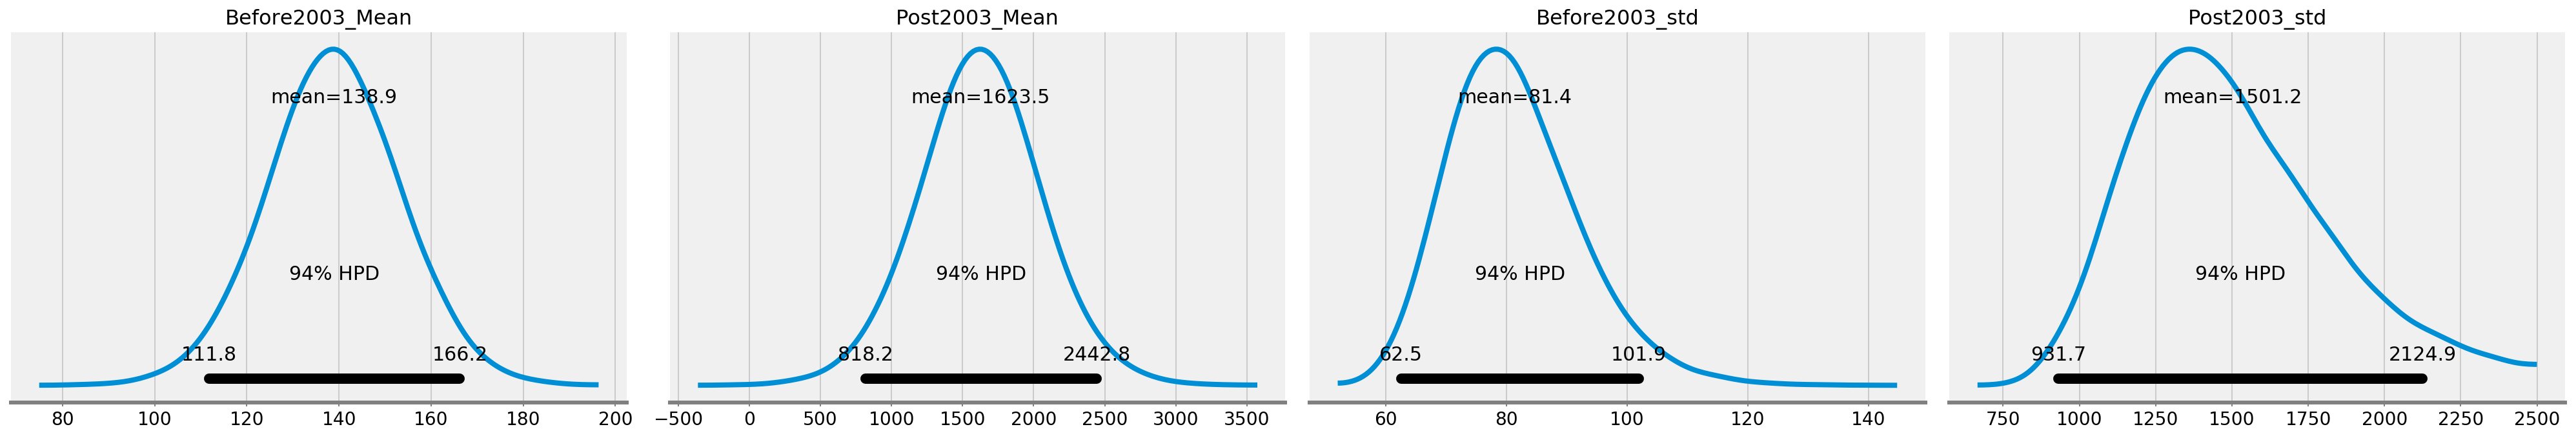

In [32]:
pm.plot_posterior(trace[3000:],
                  var_names=['Before2003_Mean', 'Post2003_Mean', 'Before2003_std', 'Post2003_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c29edf320>,
      dtype=object)

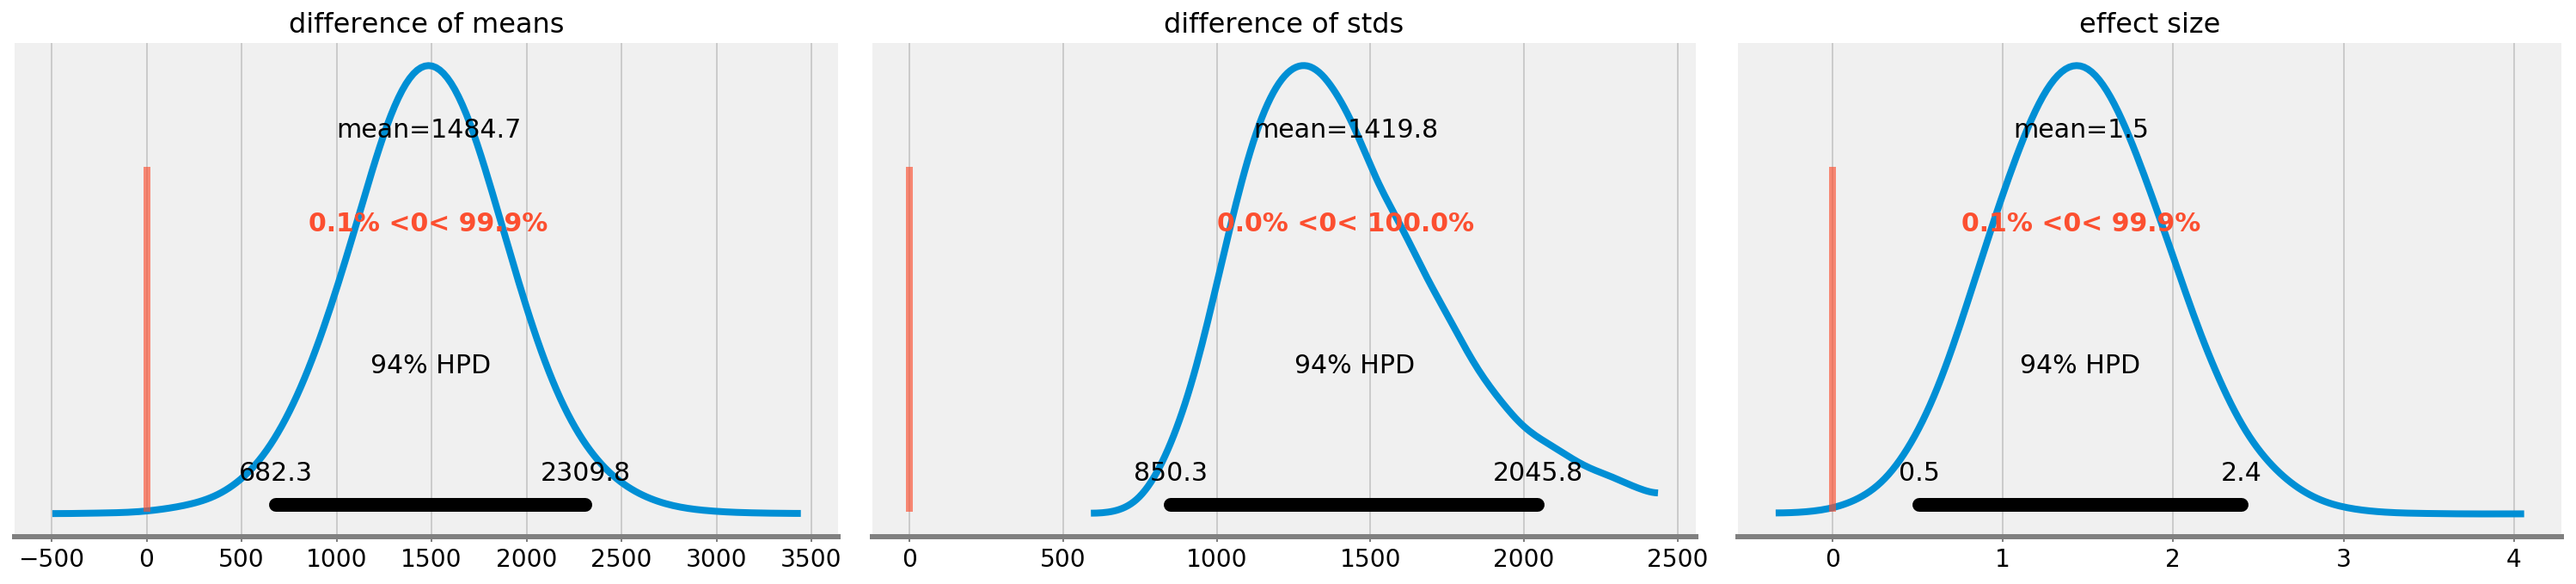

In [33]:
pm.plot_posterior(trace[3000:],
                  var_names=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [34]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,1484.660567,429.193286,2.406641,653.546578,2354.361860,41147.776254,1.000087
difference of stds,1419.807100,323.098926,2.121332,863.367737,2105.789427,18244.069319,1.000070
effect size,1.461275,0.505143,0.002714,0.484585,2.457018,34867.791629,1.000140


### From the above plots, there is a clear difference in posterior distributions of mean annual bombings in the middle east before and after 2003. I can say with a 95% credible interval that the mean bombings in the Middle East prior to 2003 lands between 110 and 166. While within the same 95% credible interval it can be stated that the annual mean bombings after 2003 is between 971 and 2700. 

## ***Part Three: Predicting 1993 Bombings***

In [35]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,1,0,1,1,NaN
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,NaN,PGIS,0,0,1,1,NaN


In [36]:
# writing a function to have one column display the entire date of the attack
def combine64(years, months=1, days=None, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return(sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None))

In [37]:
# using the above function to 
df_mideast_bombings['Date/Time_of_attack'] = combine64(df_mideast_bombings['iyear'], df_mideast_bombings['imonth']) 
                                                       

# features['datetime']=combine64(features['iyear'], features['imonth'], features['iday'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
df_mideast_bombings.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,Date/Time_of_attack
133,197003140002,1970,3,14,NaN,0,NaN,60,Egypt,10,...,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1970-03-01
158,197003290002,1970,3,29,NaN,0,NaN,110,Lebanon,10,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-03-01
195,197004150001,1970,4,15,NaN,0,NaN,102,Jordan,10,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-04-01
226,197004250001,1970,4,25,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,PGIS,1,0,1,1,NaN,1970-04-01
334,197006090002,1970,6,9,NaN,0,NaN,94,Iran,10,...,NaN,NaN,NaN,PGIS,0,0,1,1,NaN,1970-06-01


In [39]:
df_bombings['Date/Time_of_attack'] = combine64(df_bombings['iyear'], df_bombings['imonth']) 
                                               
df_bombings.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,Date/Time_of_attack
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1970-01-01
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,1970-01-01
10,197001050001,1970,1,1,NaN,0,NaN,217,United States,1,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-01-01
15,197001100001,1970,1,10,NaN,0,NaN,499,East Germany (GDR),9,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1970-01-01
17,197001120001,1970,1,12,NaN,0,NaN,217,United States,1,...,"""Blast Damages Flatbush School,"" New York Time...","Linda Greenhouse, ""Madison School Puzzled By B...",Committee on Government Operations United Stat...,Hewitt Project,-9,-9,0,-9,NaN,1970-01-01


In [40]:
regions = df_bombings.region_txt.unique()
regions

array(['Western Europe', 'North America', 'Eastern Europe',
       'Southeast Asia', 'Middle East & North Africa', 'South America',
       'Australasia & Oceania', 'East Asia',
       'Central America & Caribbean', 'South Asia', 'Sub-Saharan Africa',
       'Central Asia'], dtype=object)

In [41]:
# forming a seperate dataframe strictly consisting of the region and how many bombings per region at every given date
region_dict = {}
for r in regions:
    region_dict[r]=(df_bombings[df_bombings['region_txt']==r].groupby('Date/Time_of_attack').attacktype1.count())

region_dict['Middle East & North Africa']

Date/Time_of_attack
1970-03-01      2
1970-04-01      2
1970-06-01      2
1970-08-01      1
1970-10-01      4
1970-11-01      2
1970-12-01      1
1971-01-01      5
1971-02-01     10
1971-03-01      3
1971-04-01      6
1971-05-01      3
1971-06-01      1
1971-07-01      1
1971-09-01      3
1971-10-01      1
1971-11-01      2
1971-12-01      1
1972-01-01      5
1972-05-01     10
1972-08-01      4
1972-11-01      3
1972-12-01      1
1973-01-01      4
1973-03-01      2
1973-04-01      4
1973-05-01      2
1973-09-01      1
1973-12-01      1
1974-02-01      3
             ... 
2013-07-01    320
2013-08-01    292
2013-09-01    249
2013-10-01    318
2013-11-01    367
2013-12-01    393
2014-01-01    359
2014-02-01    400
2014-03-01    475
2014-04-01    375
2014-05-01    467
2014-06-01    326
2014-07-01    489
2014-08-01    350
2014-09-01    279
2014-10-01    320
2014-11-01    297
2014-12-01    282
2015-01-01    324
2015-02-01    310
2015-03-01    319
2015-04-01    298
2015-05-01    321
2015-06-

In [43]:
df_bombings_by_region = pd.DataFrame(region_dict)
print(df_bombings_by_region.shape)
df_bombings_by_region

(540, 12)


,Western Europe,North America,Eastern Europe,Southeast Asia,Middle East & North Africa,South America,Australasia & Oceania,East Asia,Central America & Caribbean,South Asia,Sub-Saharan Africa,Central Asia
Date/Time_of_attack,,,,,,,,,,,,
1970-01-01,1.0,12.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-01,2.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-01,2.0,36.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,NaN,43.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,1.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-06-01,NaN,22.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-07-01,1.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-08-01,2.0,13.0,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-09-01,2.0,14.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_bombings_by_region.index

DatetimeIndex(['1970-01-01', '1970-02-01', '1970-03-01', '1970-04-01',
               '1970-05-01', '1970-06-01', '1970-07-01', '1970-08-01',
               '1970-09-01', '1970-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name='Date/Time_of_attack', length=540, freq=None)

In [45]:
# dataframe of the count of bombings in every region indexed by month from 1970 - 2016.
df_bombings_by_region = df_bombings_by_region.fillna(0)

In [46]:
df_bombings_by_region.head()

,Western Europe,North America,Eastern Europe,Southeast Asia,Middle East & North Africa,South America,Australasia & Oceania,East Asia,Central America & Caribbean,South Asia,Sub-Saharan Africa,Central Asia
Date/Time_of_attack,,,,,,,,,,,,
1970-01-01,1.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-02-01,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-03-01,2.0,36.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-04-01,0.0,43.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-05-01,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_bombings_by_region.shape

(540, 12)

In [48]:
df_bombings_by_region[250:300]

,Western Europe,North America,Eastern Europe,Southeast Asia,Middle East & North Africa,South America,Australasia & Oceania,East Asia,Central America & Caribbean,South Asia,Sub-Saharan Africa,Central Asia
Date/Time_of_attack,,,,,,,,,,,,
1990-11-01,13.0,0.0,2.0,10.0,7.0,20.0,0.0,17.0,20.0,9.0,14.0,0.0
1990-12-01,19.0,0.0,0.0,3.0,8.0,36.0,0.0,3.0,14.0,3.0,4.0,0.0
1991-01-01,65.0,3.0,0.0,13.0,36.0,45.0,0.0,1.0,35.0,19.0,4.0,0.0
1991-02-01,25.0,0.0,1.0,6.0,27.0,66.0,0.0,3.0,4.0,25.0,5.0,0.0
1991-03-01,37.0,1.0,4.0,5.0,37.0,20.0,0.0,0.0,7.0,14.0,6.0,0.0
1991-04-01,19.0,1.0,3.0,13.0,36.0,47.0,0.0,0.0,17.0,18.0,1.0,0.0
1991-05-01,29.0,1.0,2.0,8.0,12.0,52.0,0.0,0.0,41.0,5.0,5.0,0.0
1991-06-01,26.0,1.0,2.0,3.0,19.0,60.0,0.0,0.0,25.0,13.0,2.0,0.0
1991-07-01,30.0,0.0,15.0,8.0,12.0,106.0,0.0,1.0,25.0,20.0,4.0,0.0


In [49]:
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Austalasia & Oceania

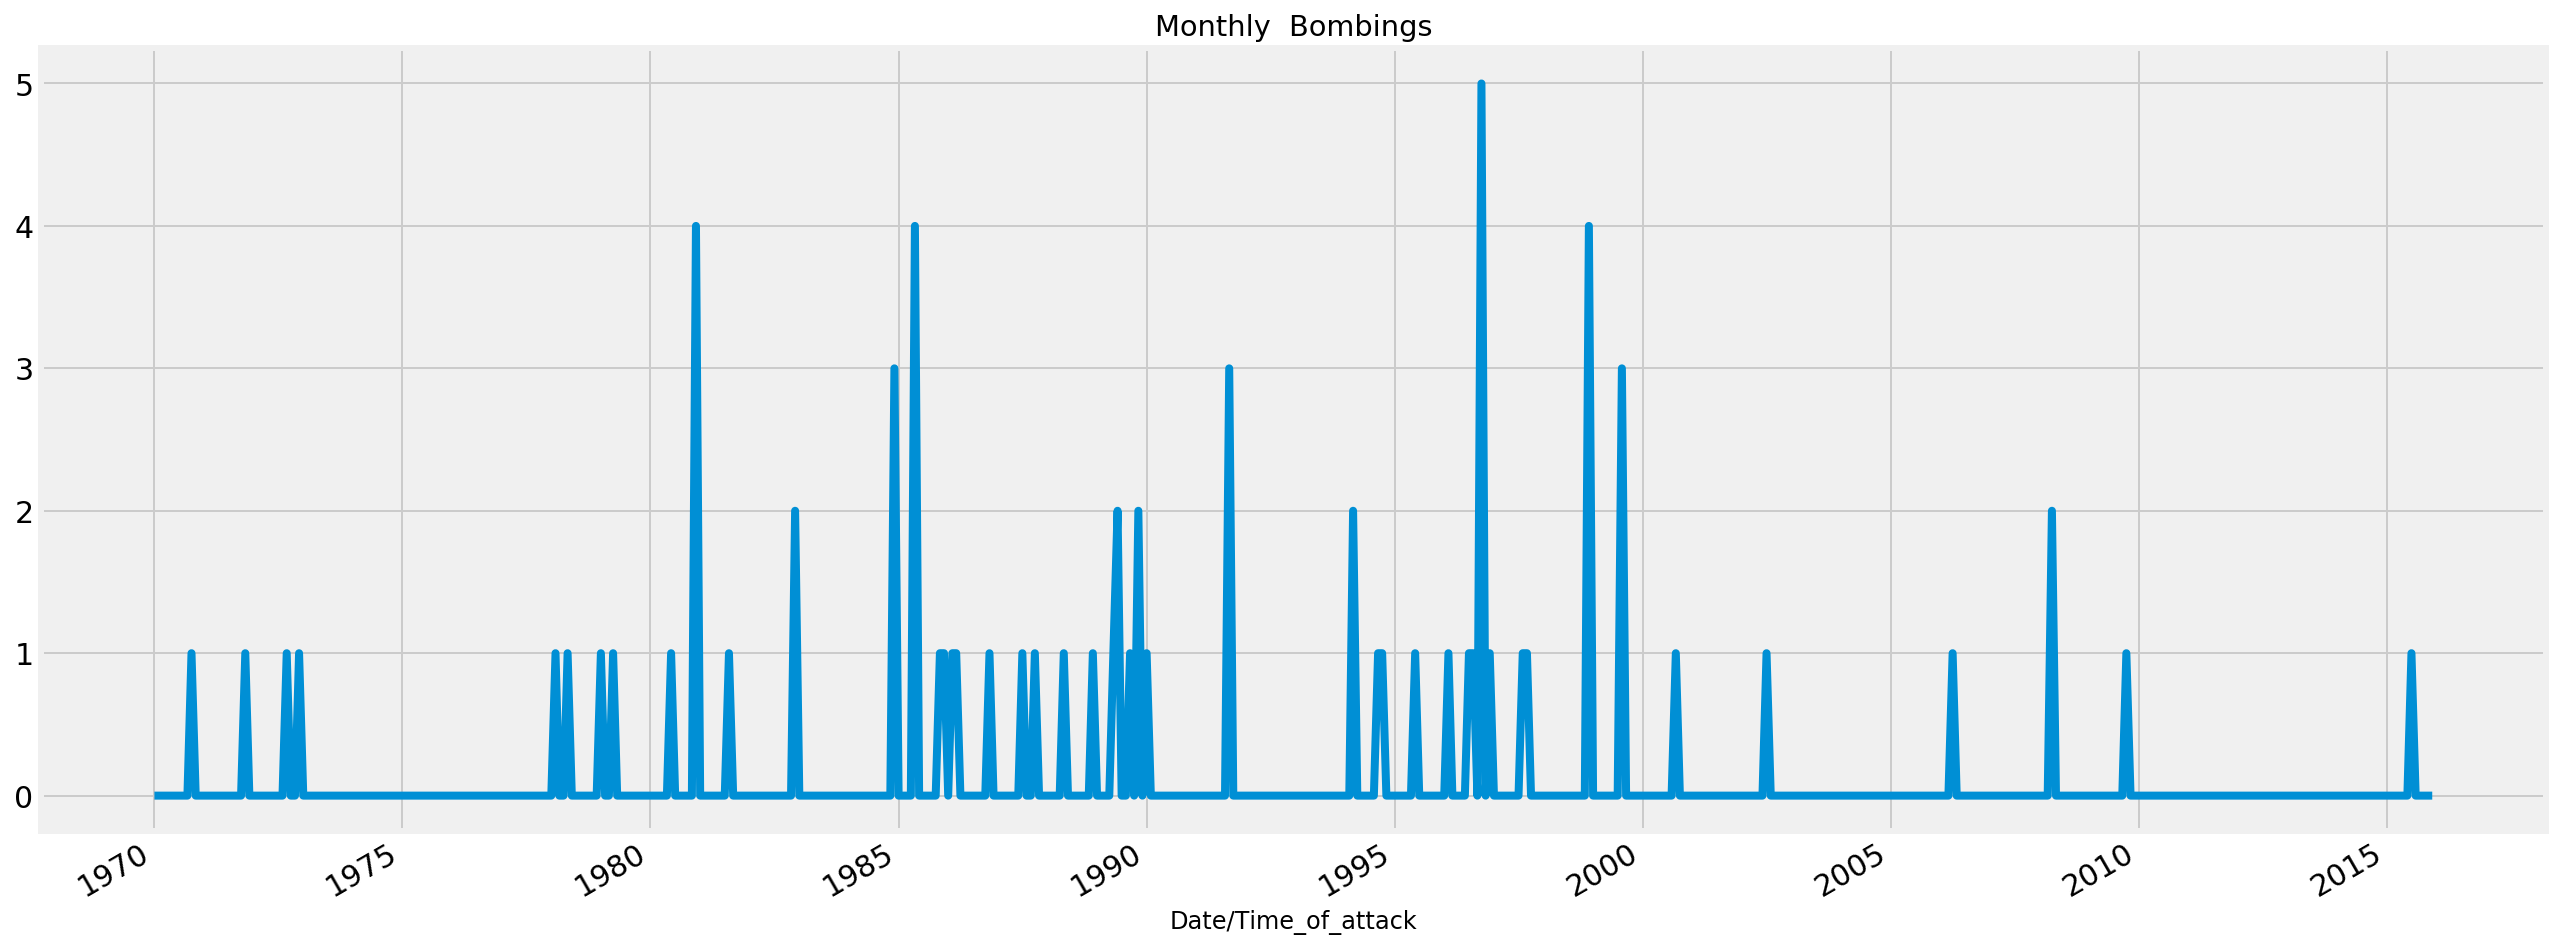

In [50]:
df_bombings_by_region['Australasia & Oceania'].plot(figsize=(20,8), fontsize=15, title='Monthly  Bombings')

<Figure size 432x288 with 0 Axes>

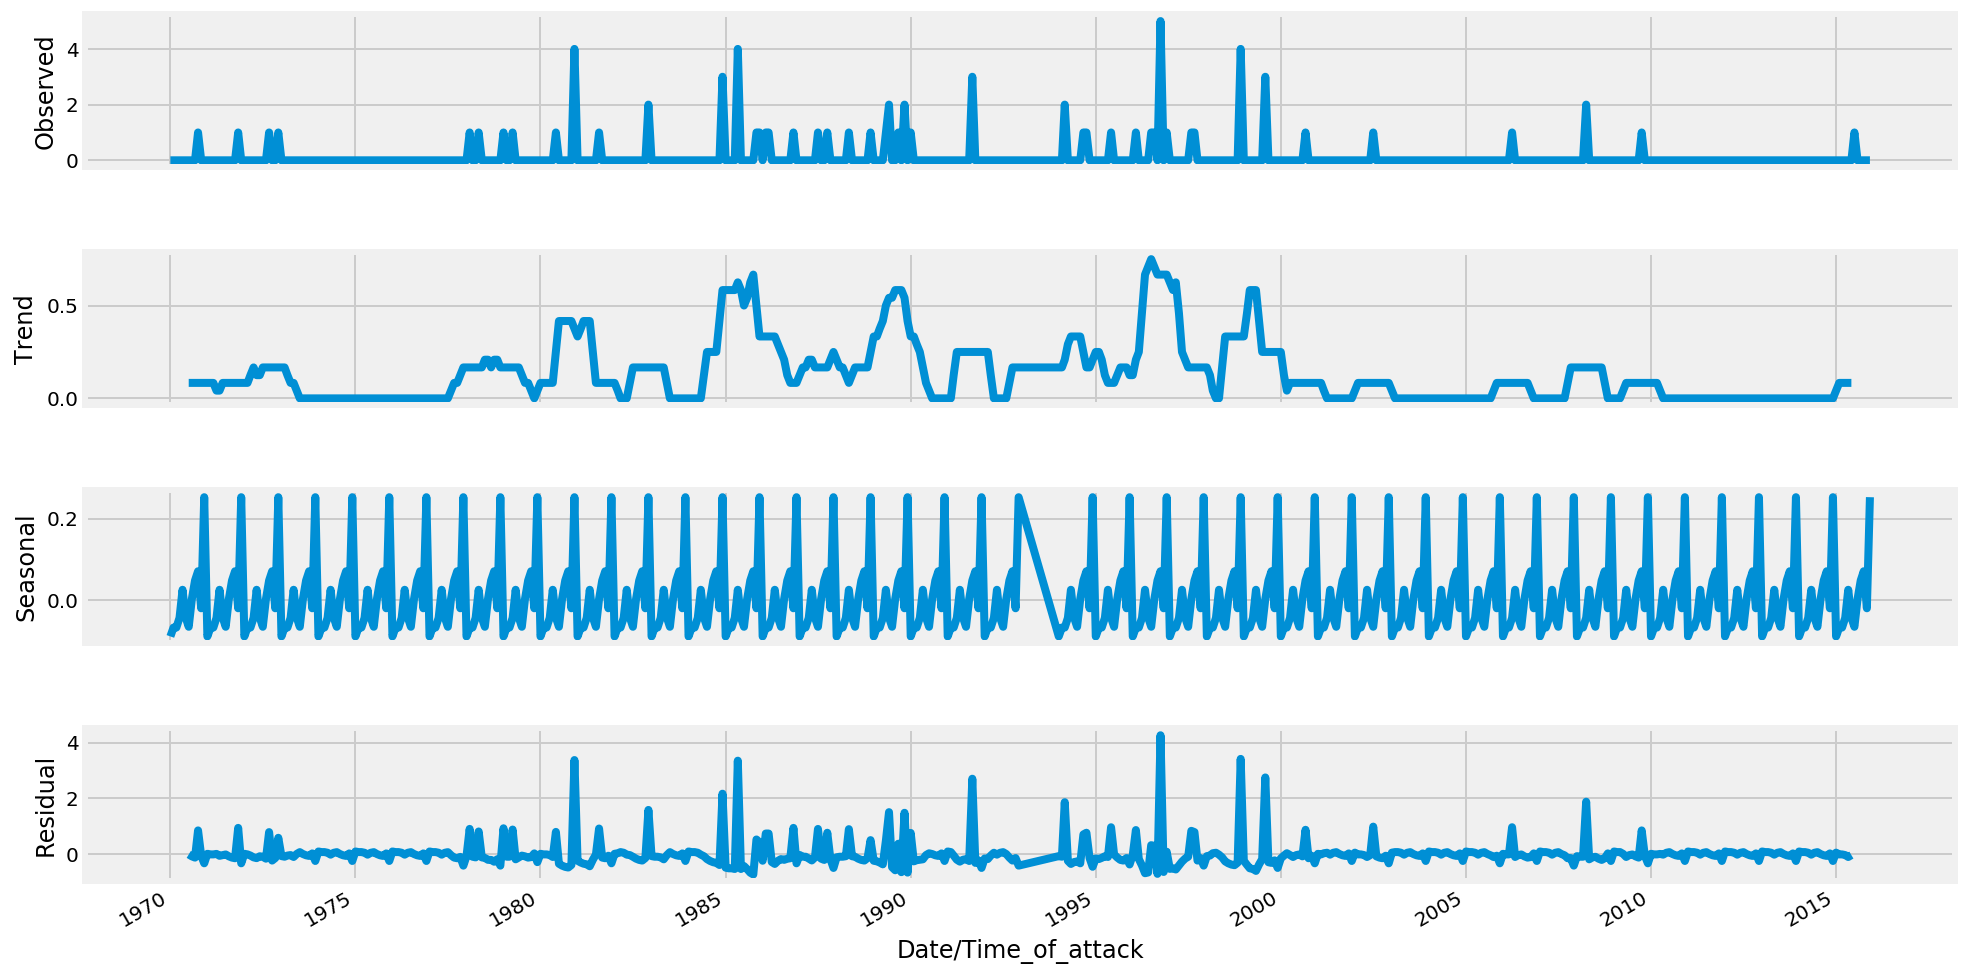

In [51]:
decomposition = seasonal_decompose(df_bombings_by_region['Australasia & Oceania'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)



# decomposition = seasonal_decompose(df.riders, freq=12)  
# fig = plt.figure()  
# fig = decomposition.plot()  
# fig.set_size_inches(15, 8)

In [56]:
### Stationizing the data
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std() 

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

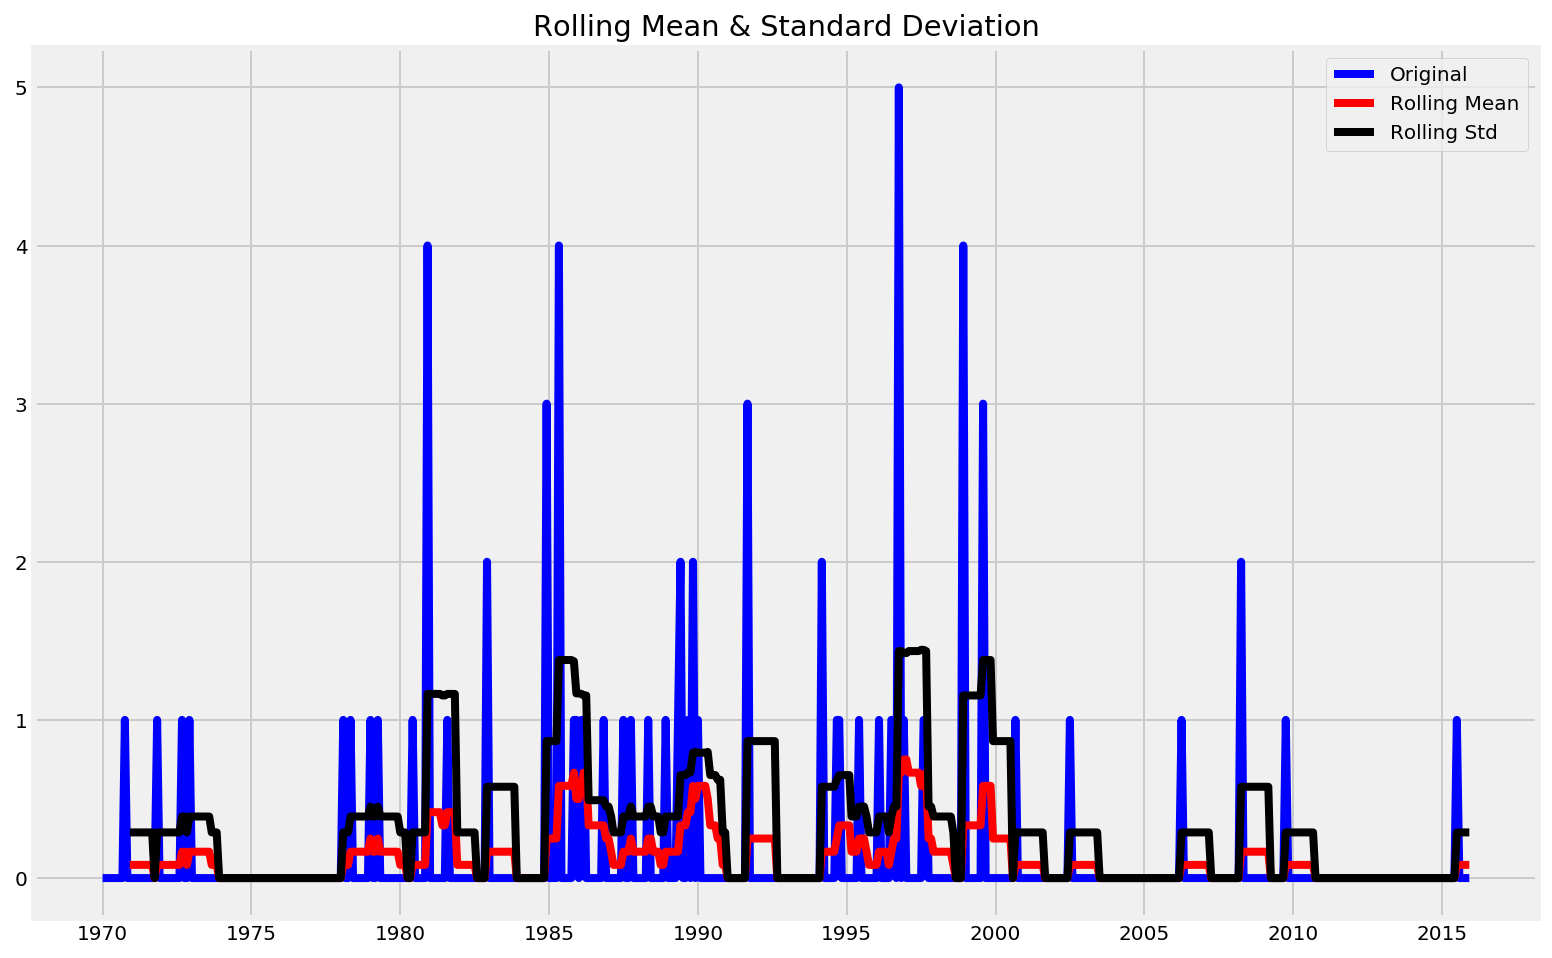

Results of Dickey-Fuller Test:
Test Statistic                 -23.591450
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    539.000000
Critical Value (1%)             -3.442541
Critical Value (5%)             -2.866917
Critical Value (10%)            -2.569634
dtype: float64


In [57]:
test_stationarity(df_bombings_by_region['Australasia & Oceania'])

In [58]:
from statsmodels.tsa.arima_model import ARMA

In [61]:
model = ARMA(df_bombings_by_region['Australasia & Oceania'], (1,0)).fit()
model.summary()

# model = ARMA(store1_sales_data, (1, 1)).fit()
# model.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     Australasia & Oceania   No. Observations:                  540
Model:                        ARMA(1, 0)   Log Likelihood                -413.729
Method:                          css-mle   S.D. of innovations              0.521
Date:                   Sat, 06 Jul 2019   AIC                            833.459
Time:                           18:58:50   BIC                            846.334
Sample:                                0   HQIC                           838.494
                                                                                 
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1333      0.022      6.058      0.000       0.090       0.176
ar.L1.Australasia & Oceania    -0.0179      0.043     -0.415      0.678      -0.102       0.066
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -56.0152           +0.0000j           56.0152            0.5000
-----------------------------------------------------------------------------
"""

In [62]:
model = ARMA(df_bombings_by_region['Australasia & Oceania'], (2,1)).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     Australasia & Oceania   No. Observations:                  540
Model:                        ARMA(2, 1)   Log Likelihood                -410.674
Method:                          css-mle   S.D. of innovations              0.518
Date:                   Sat, 06 Jul 2019   AIC                            831.347
Time:                           18:58:56   BIC                            852.805
Sample:                                0   HQIC                           839.739
                                                                                 
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1209      0.050      2.427      0.016       0.023       0.219
ar.L1.Australasia & Oceania     0.9424      0.046     20.322      0.000       0.852       1.033
ar.L2.Australasia & Oceania     0.0451      0.043      1.038      0.300      -0.040       0.130
ma.L1.Australasia & Oceania    -0.9709      0.018    -53.945      0.000      -1.006      -0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0121           +0.0000j            1.0121            0.0000
AR.2          -21.9078           +0.0000j           21.9078            0.5000
MA.1            1.0299           +0.0000j            1.0299            0.0000
-----------------------------------------------------------------------------
"""

In [63]:
# Formulating predictions for the model 
df_bombings_by_region['forecast'] = model.predict(start = 250, end = 300, dynamic=True) 

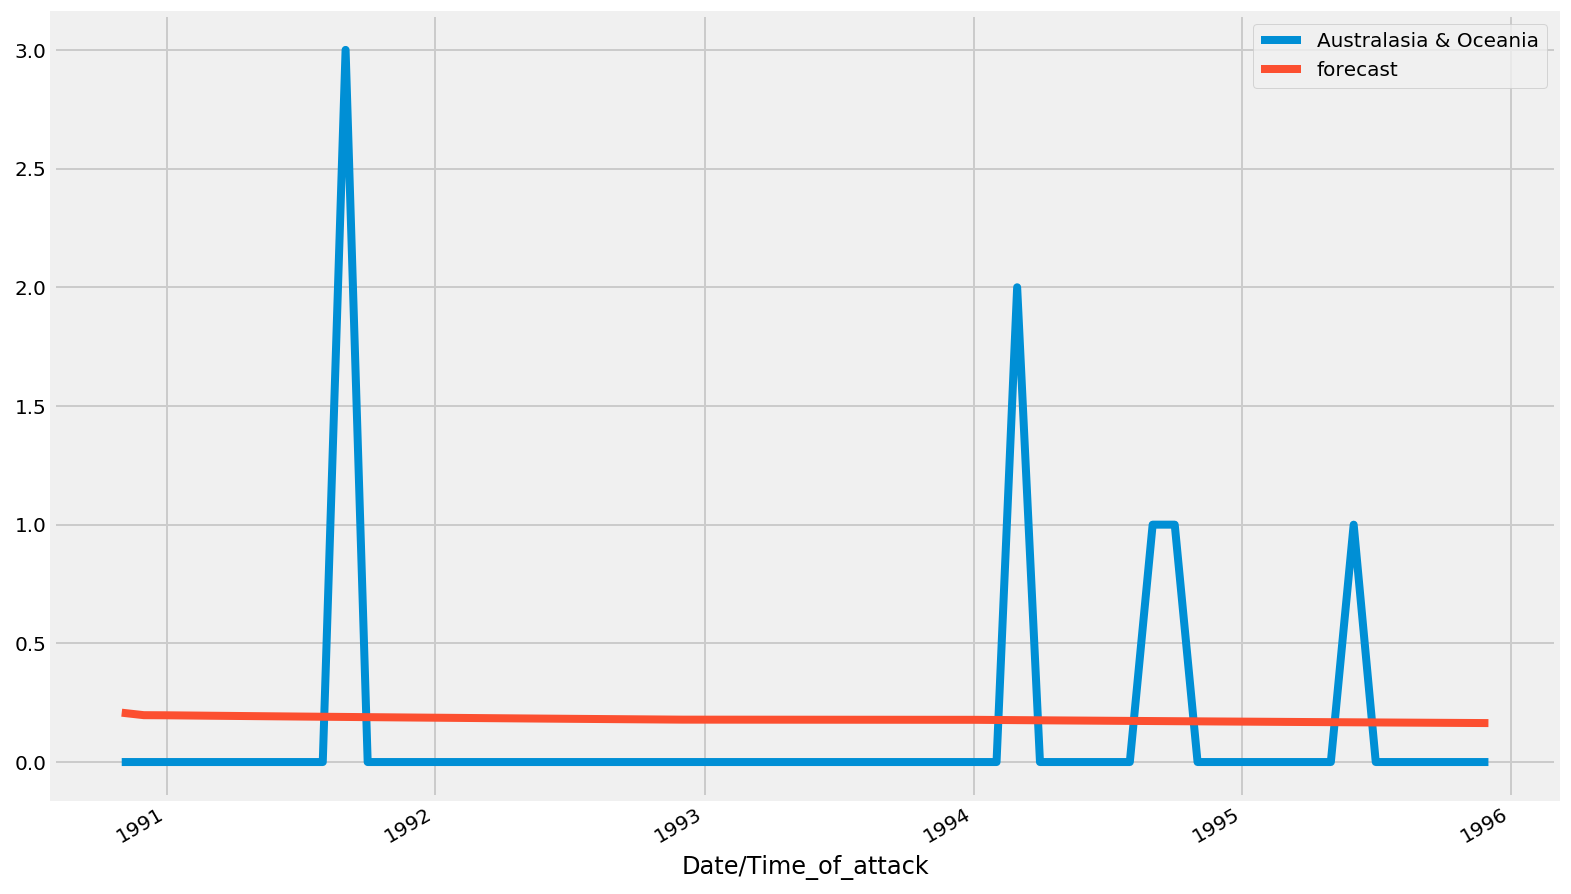

In [67]:
df_bombings_by_region[['Australasia & Oceania', 'forecast']][250:300].plot(figsize=(12, 8)) 

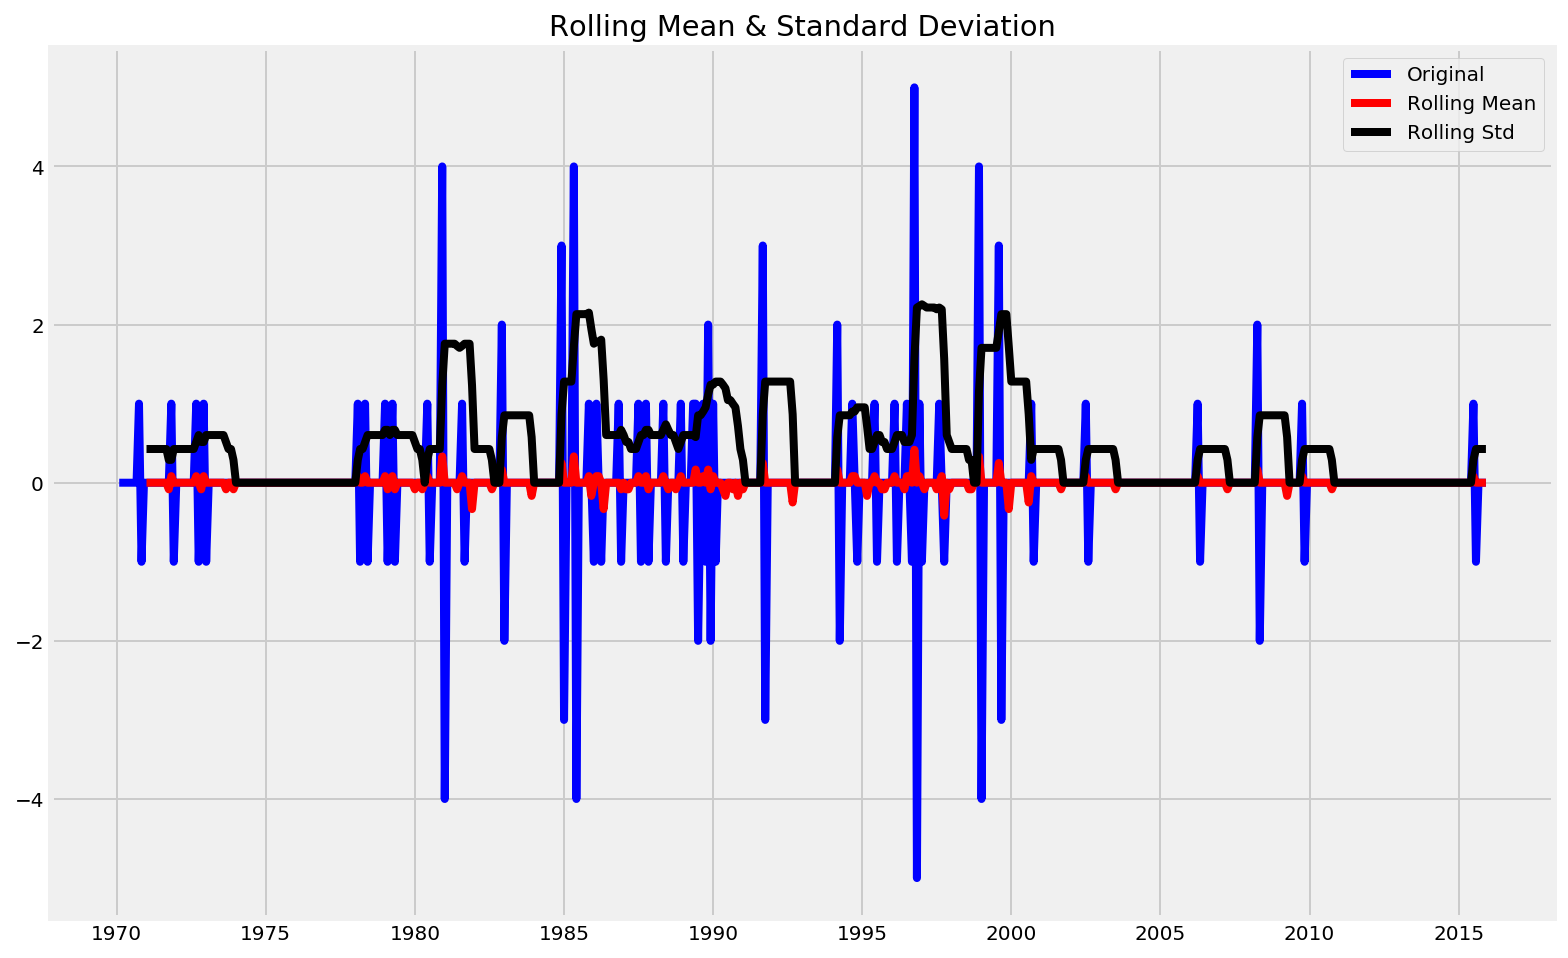

Results of Dickey-Fuller Test:
Test Statistic                -1.247048e+01
p-value                        3.253257e-23
#Lags Used                     9.000000e+00
Number of Observations Used    5.290000e+02
Critical Value (1%)           -3.442772e+00
Critical Value (5%)           -2.867019e+00
Critical Value (10%)          -2.569688e+00
dtype: float64


In [70]:
df_bombings_by_region['first_difference'] = (df_bombings_by_region['Australasia & Oceania'] - 
                                             df_bombings_by_region['Australasia & Oceania'].shift(1)  
                                            )
test_stationarity(df_bombings_by_region.first_difference.dropna(inplace=False))

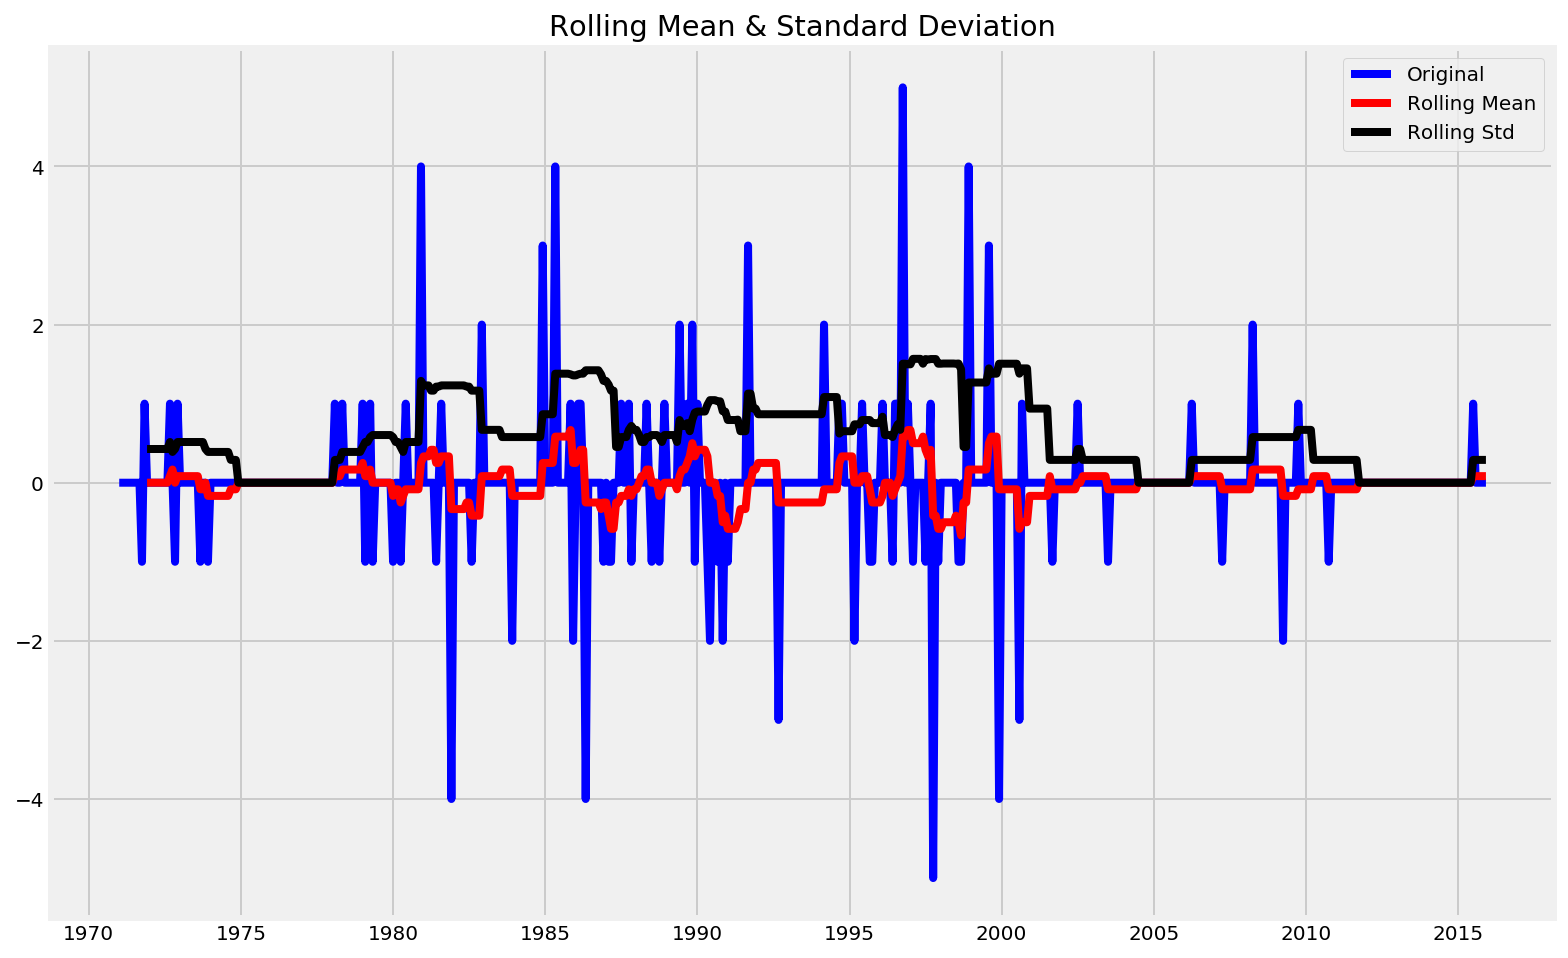

Results of Dickey-Fuller Test:
Test Statistic                -6.464950e+00
p-value                        1.412819e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [71]:
df_bombings_by_region['seasonal_difference'] = (df_bombings_by_region['Australasia & Oceania'] - 
                                                    df_bombings_by_region['Australasia & Oceania'].shift(12) 
                                               )
test_stationarity(df_bombings_by_region.seasonal_difference.dropna(inplace=False))

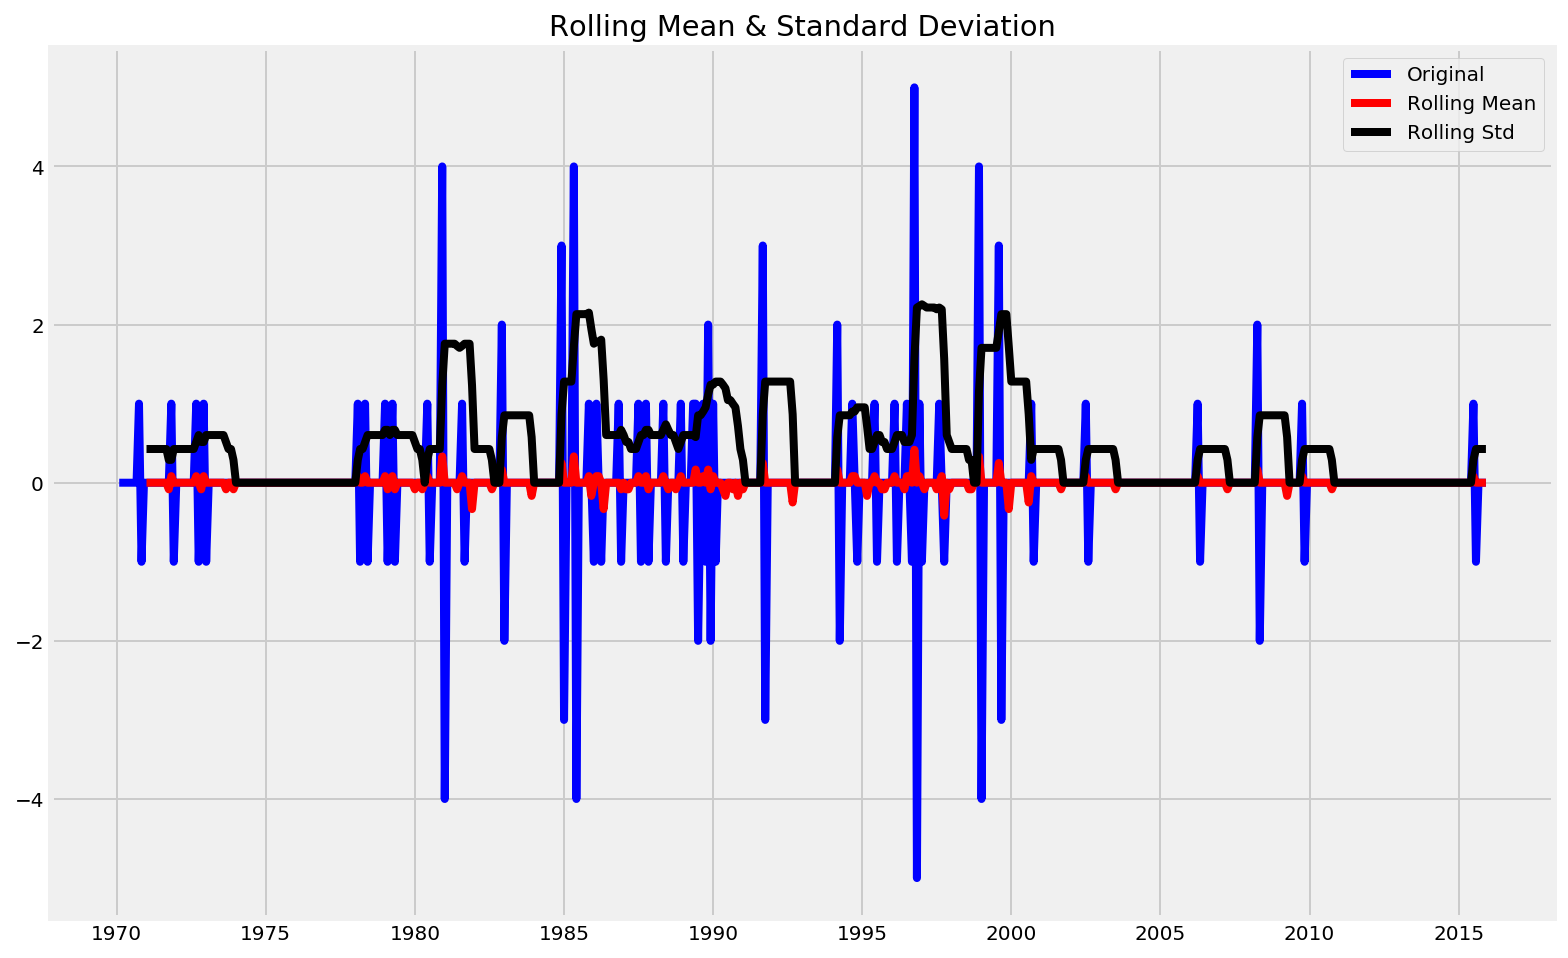

Results of Dickey-Fuller Test:
Test Statistic                -1.247048e+01
p-value                        3.253257e-23
#Lags Used                     9.000000e+00
Number of Observations Used    5.290000e+02
Critical Value (1%)           -3.442772e+00
Critical Value (5%)           -2.867019e+00
Critical Value (10%)          -2.569688e+00
dtype: float64


In [72]:
df_bombings_by_region['seasonal_first_difference'] = (df_bombings_by_region['first_difference'] -
                                                      df_bombings_by_region['first_difference'].shift(12)  
                                                     )
test_stationarity(df_bombings_by_region.first_difference.dropna(inplace=False))                                  

### North America

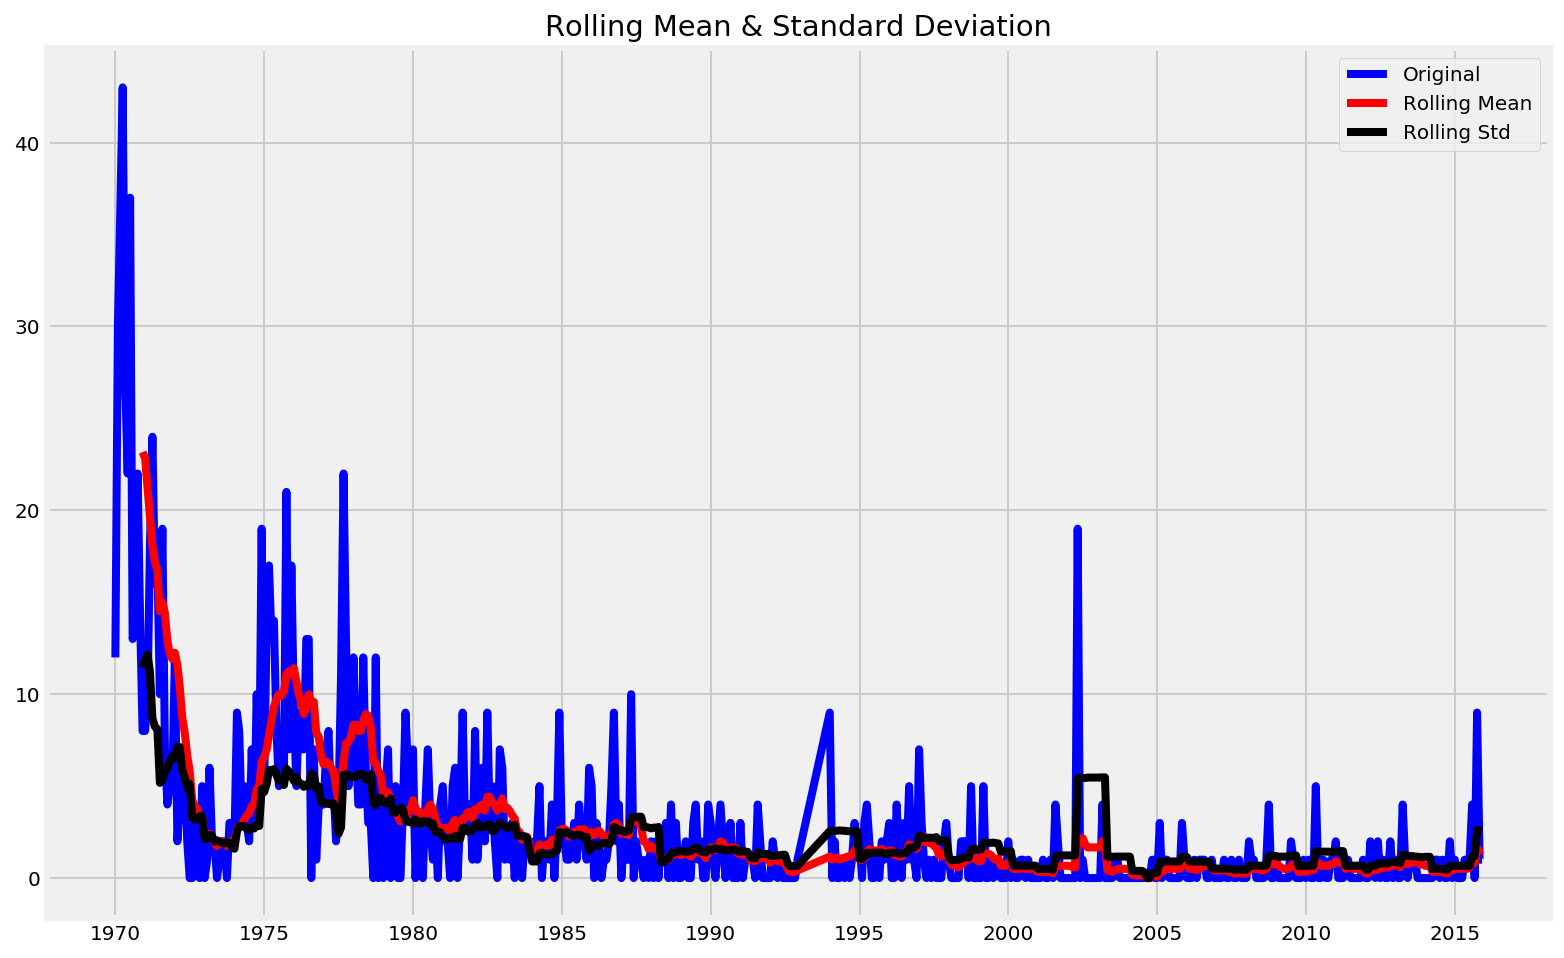

Results of Dickey-Fuller Test:
Test Statistic                  -4.779412
p-value                          0.000060
#Lags Used                      17.000000
Number of Observations Used    522.000000
Critical Value (1%)             -3.442940
Critical Value (5%)             -2.867093
Critical Value (10%)            -2.569727
dtype: float64


In [73]:
test_stationarity(df_bombings_by_region['North America'])

In [82]:
NA_model = ARMA(df_bombings_by_region['North America'], (1,1)).fit()
NA_model.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          North America   No. Observations:                  540
Model:                     ARMA(1, 1)   Log Likelihood               -1400.539
Method:                       css-mle   S.D. of innovations              3.229
Date:                Sat, 06 Jul 2019   AIC                           2809.079
Time:                        19:04:03   BIC                           2826.245
Sample:                             0   HQIC                          2815.793
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.6655      5.569      1.197      0.232      -4.249      17.580
ar.L1.North America     0.9934      0.007    136.619      0.000       0.979       1.008
ma.L1.North America    -0.7149      0.035    -20.637      0.000      -0.783      -0.647
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0067           +0.0000j            1.0067            0.0000
MA.1            1.3988           +0.0000j            1.3988            0.0000
-----------------------------------------------------------------------------
"""

In [80]:
NA_model_2 = ARMA(df_bombings_by_region['North America'], (0,1)).fit()
NA_model_2.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          North America   No. Observations:                  540
Model:                     ARMA(0, 1)   Log Likelihood               -1539.967
Method:                       css-mle   S.D. of innovations              4.190
Date:                Sat, 06 Jul 2019   AIC                           3085.934
Time:                        19:03:50   BIC                           3098.809
Sample:                             0   HQIC                          3090.970
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8124      0.270     10.433      0.000       2.284       3.341
ma.L1.North America     0.4960      0.031     15.903      0.000       0.435       0.557
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.0160           +0.0000j            2.0160            0.5000
-----------------------------------------------------------------------------
"""

In [81]:
NA_model_3 = ARMA(df_bombings_by_region['North America'], (2,1)).fit()
NA_model_3.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          North America   No. Observations:                  540
Model:                     ARMA(2, 1)   Log Likelihood               -1400.086
Method:                       css-mle   S.D. of innovations              3.226
Date:                Sat, 06 Jul 2019   AIC                           2810.173
Time:                        19:03:54   BIC                           2831.631
Sample:                             0   HQIC                          2818.565
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.9834      5.938      1.176      0.240      -4.654      18.621
ar.L1.North America     1.0538      0.063     16.668      0.000       0.930       1.178
ar.L2.North America    -0.0592      0.062     -0.957      0.339      -0.180       0.062
ma.L1.North America    -0.7444      0.042    -17.734      0.000      -0.827      -0.662
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0057           +0.0000j            1.0057            0.0000
AR.2           16.8043           +0.0000j           16.8043            0.0000
MA.1            1.3434           +0.0000j            1.3434            0.0000
-----------------------------------------------------------------------------
"""

In [83]:
# Of the above three models, the first proved to be the most accurate due to the lowest AIC score
# Formulating predictions for the model 
df_bombings_by_region['NA_forecast'] = NA_model.predict(start = 250, end = 300, dynamic=True) 

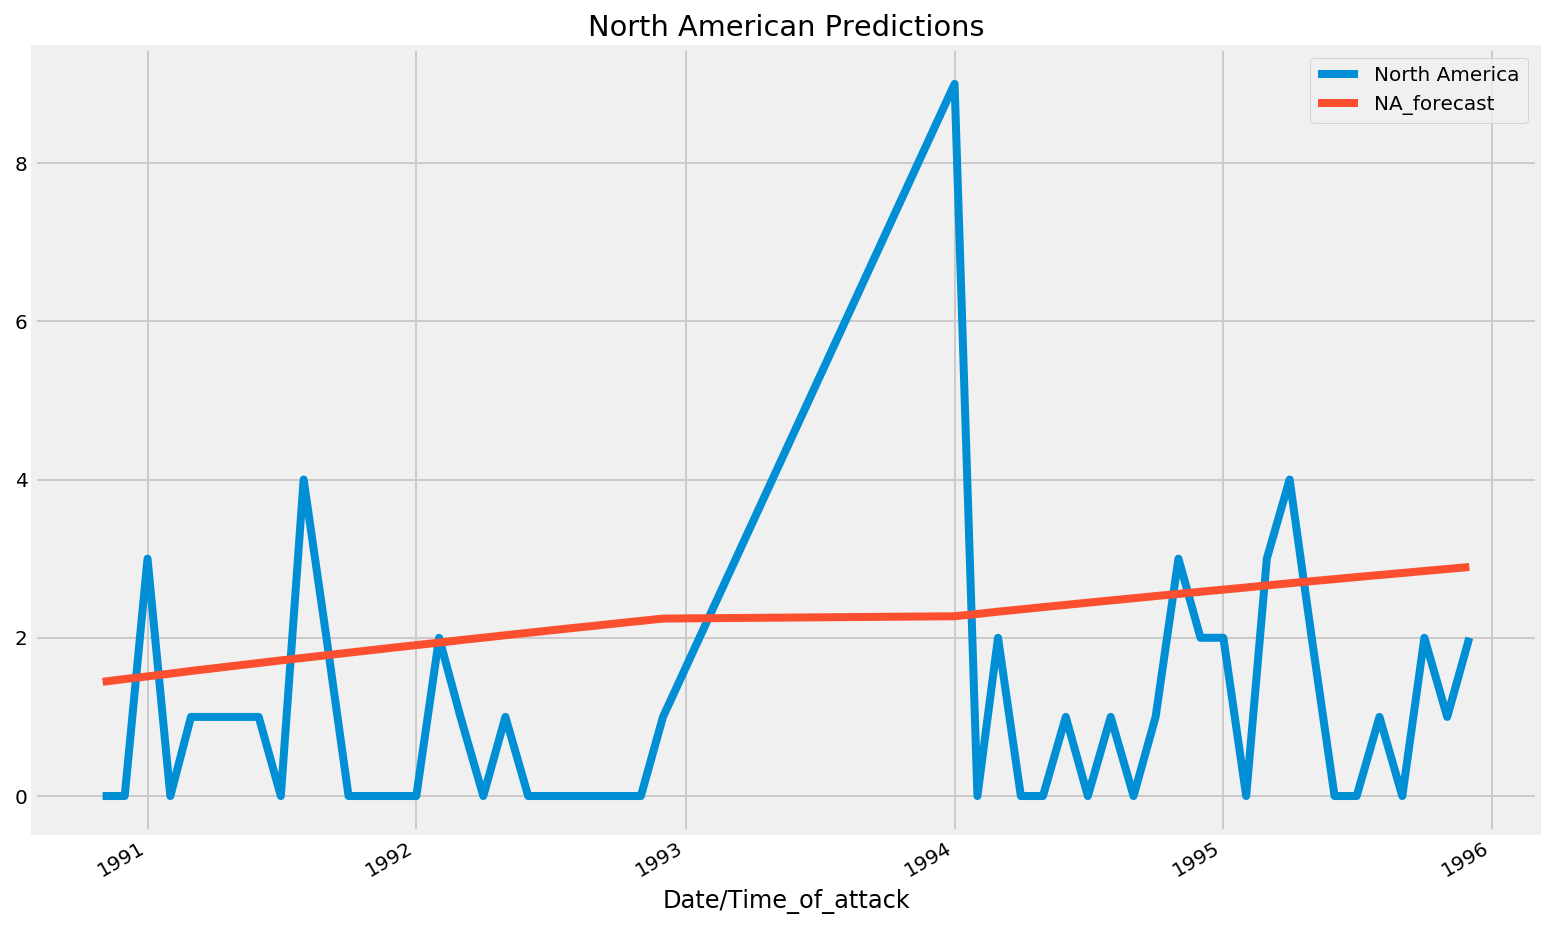

In [86]:
# plotting predictions for North America
df_bombings_by_region[['North America', 'NA_forecast']][250:300].plot(figsize=(12, 8), 
                                                                      title='North American Predictions')

### Central America & Caribbean

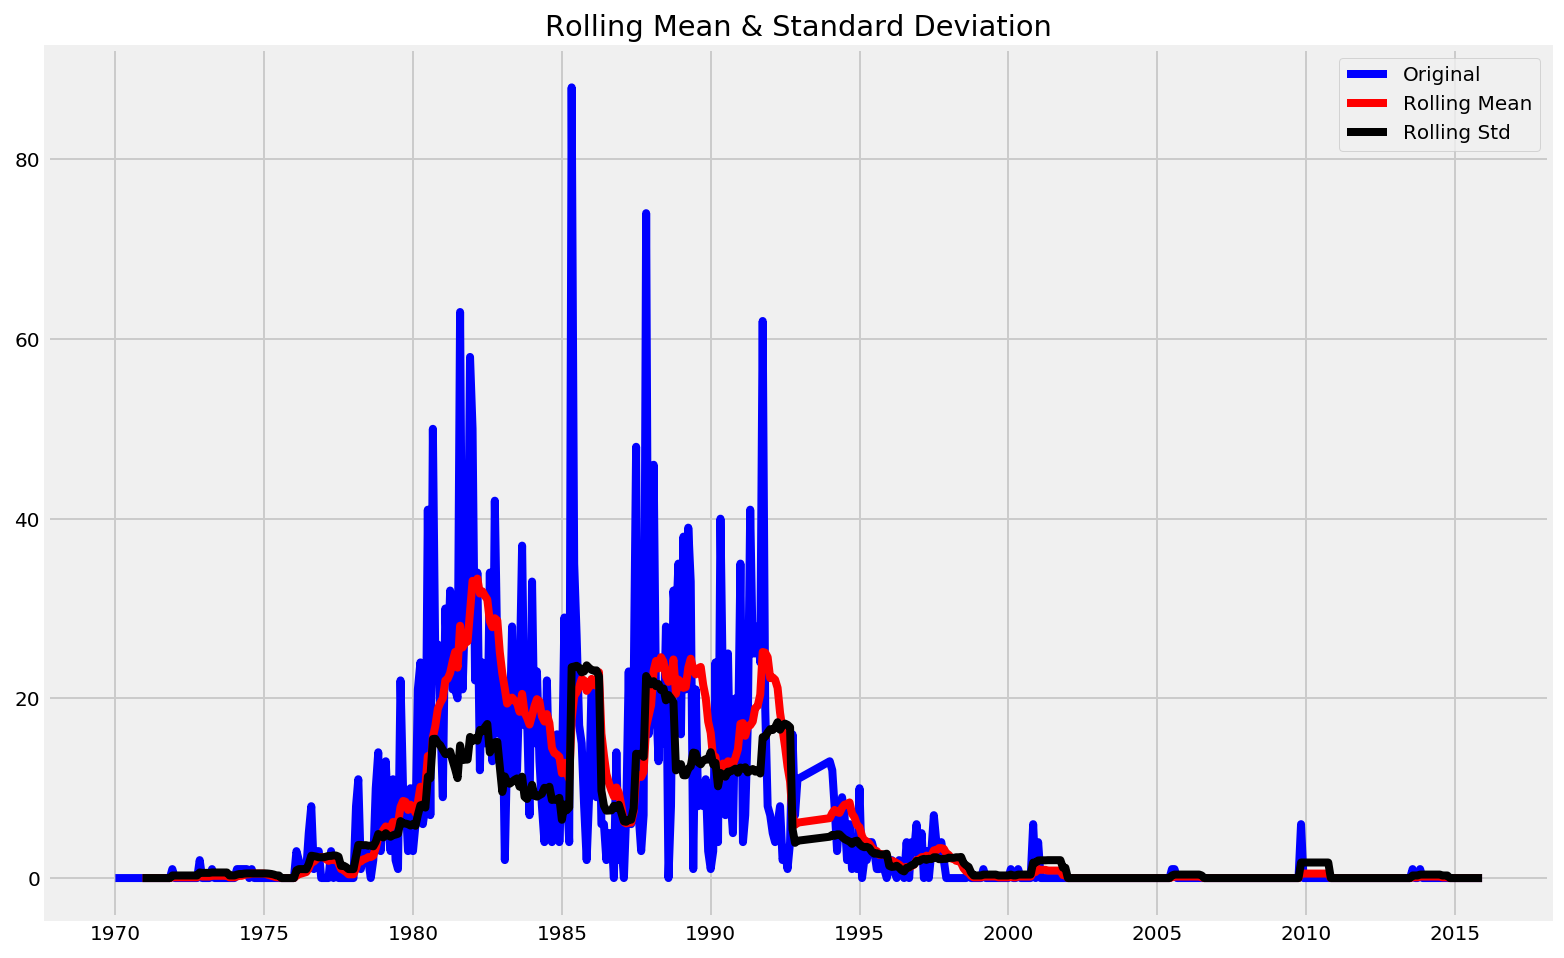

Results of Dickey-Fuller Test:
Test Statistic                  -2.129492
p-value                          0.232822
#Lags Used                      18.000000
Number of Observations Used    521.000000
Critical Value (1%)             -3.442964
Critical Value (5%)             -2.867103
Critical Value (10%)            -2.569733
dtype: float64


In [87]:
test_stationarity(df_bombings_by_region['Central America & Caribbean'])

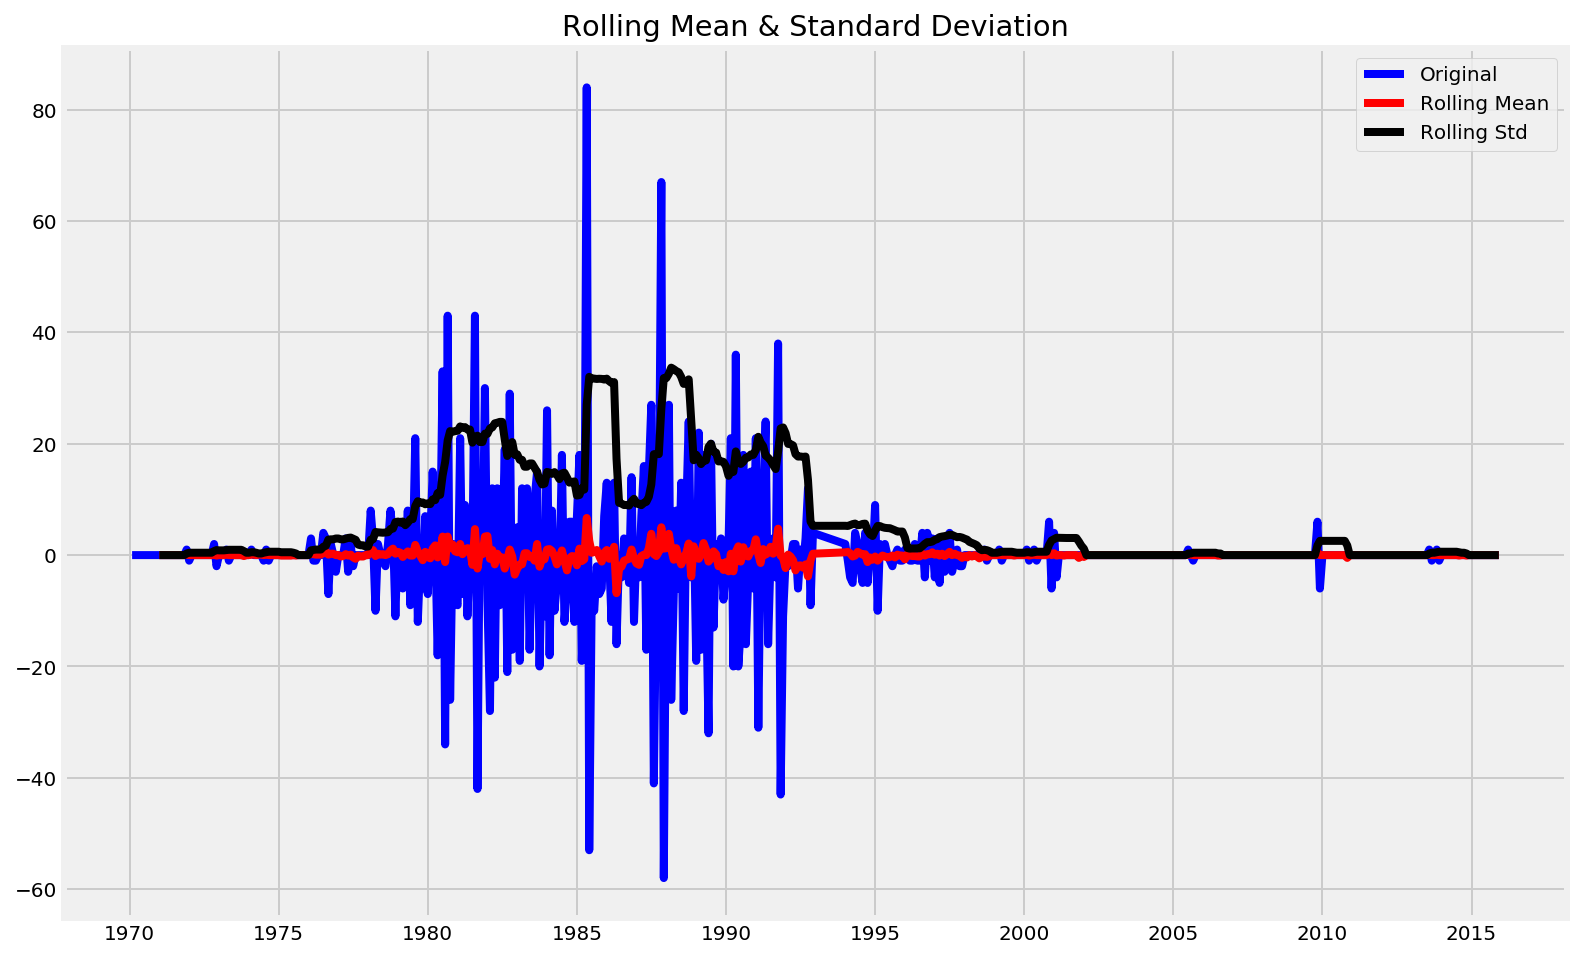

Results of Dickey-Fuller Test:
Test Statistic                -6.728809e+00
p-value                        3.336397e-09
#Lags Used                     1.700000e+01
Number of Observations Used    5.210000e+02
Critical Value (1%)           -3.442964e+00
Critical Value (5%)           -2.867103e+00
Critical Value (10%)          -2.569733e+00
dtype: float64


In [88]:
# Given that the above Test Statistic is greater than the 5% Critical Value, the data is not stationary. 
# testing the first difference for stationarity 
df_bombings_by_region['CA_Caribbean_first_difference'] = df_bombings_by_region['Central America & Caribbean'] - df_bombings_by_region['Central America & Caribbean'].shift(1)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))

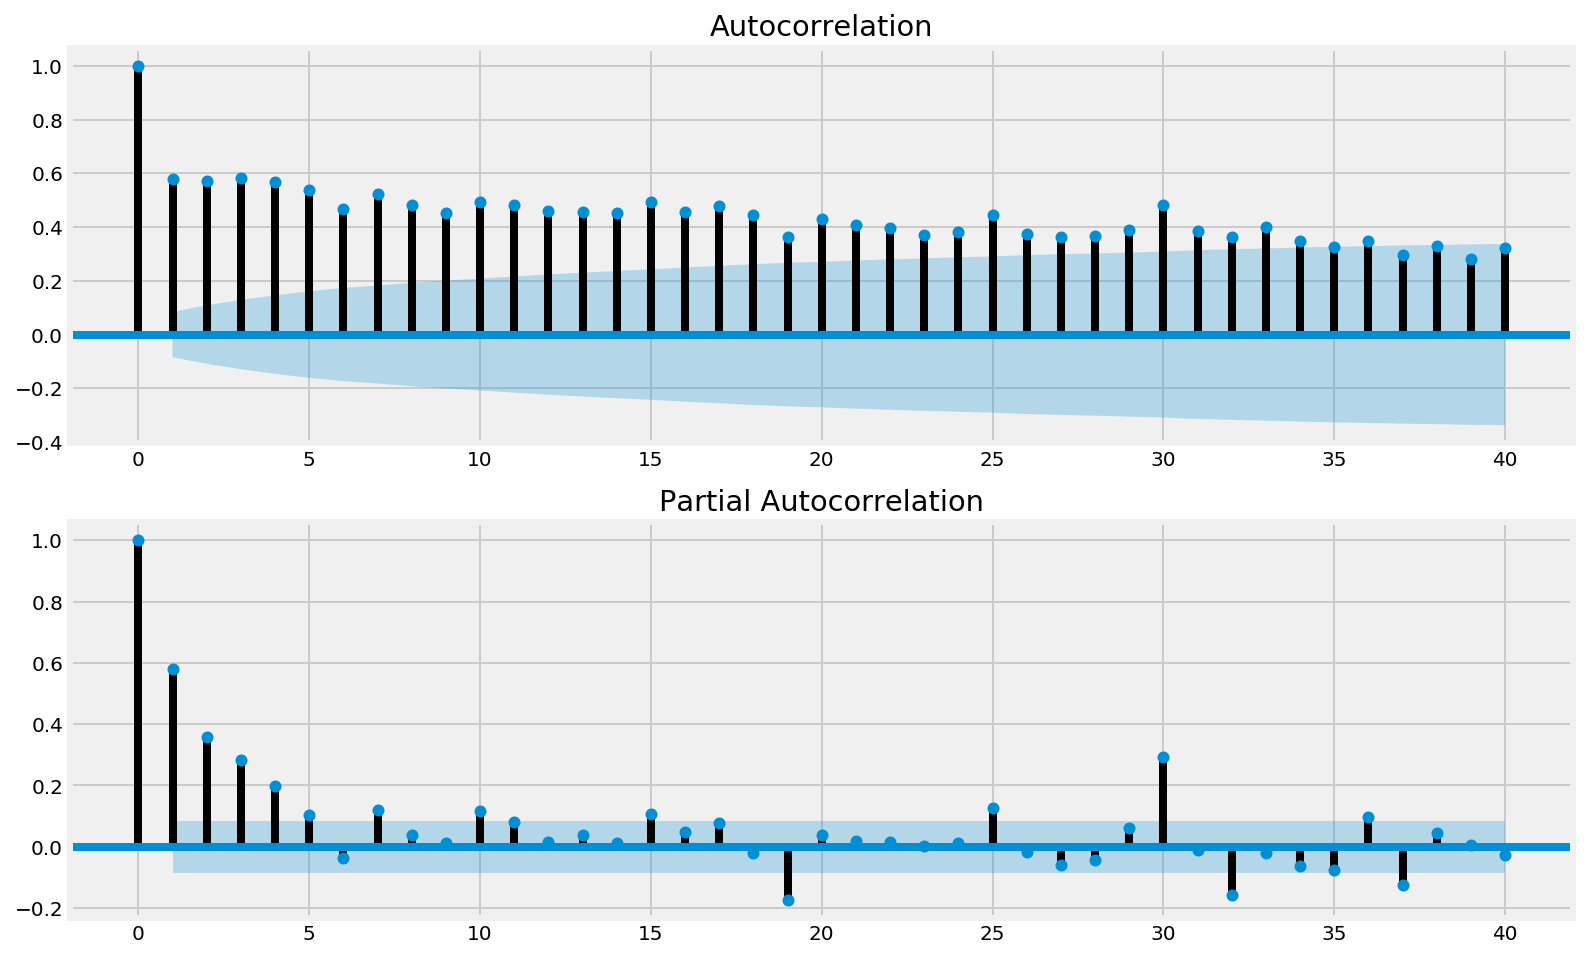

In [89]:
# Now that Test-Statistic is below the 5% Critical Value Mark, data is stationary and we can proceed with modeling
# Plotting Auto-Correlation and Partion AC to check for optimal parameters
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_bombings_by_region['Central America & Caribbean'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_bombings_by_region['Central America & Caribbean'], lags=40, ax=ax2)

In [90]:
CA_model = sm.tsa.statespace.SARIMAX(df_bombings_by_region['Central America & Caribbean'],
                                     trend='n',
                                     order=(1,1,0),
                                     seasonal_order=(0,1,1,12))

results = CA_model.fit()
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:        Central America & Caribbean   No. Observations:                  540
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -1938.373
Date:                            Sat, 06 Jul 2019   AIC                           3882.745
Time:                                    19:04:41   BIC                           3895.547
Sample:                                         0   HQIC                          3887.757
                                            - 540                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4882      0.020    -24.382      0.000      -0.527      -0.449
ma.S.L12      -0.9991      2.034     -0.491      0.623      -4.985       2.987
sigma2        84.1070    169.719      0.496      0.620    -248.537     416.751
===================================================================================
Ljung-Box (Q):                      234.54   Jarque-Bera (JB):              8261.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             2.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
CA_model_2 = sm.tsa.statespace.SARIMAX(df_bombings_by_region['Central America & Caribbean'],
                                     trend='n',
                                     order=(0,1,1),
                                     seasonal_order=(0,1,1,12))

results2 = CA_model_2.fit()
results2.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:        Central America & Caribbean   No. Observations:                  540
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1880.485
Date:                            Sat, 06 Jul 2019   AIC                           3766.971
Time:                                    19:04:42   BIC                           3779.773
Sample:                                         0   HQIC                          3771.983
                                            - 540                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8047      0.019    -41.371      0.000      -0.843      -0.767
ma.S.L12      -0.9994      3.265     -0.306      0.760      -7.398       5.399
sigma2        67.3782    219.063      0.308      0.758    -361.978     496.734
===================================================================================
Ljung-Box (Q):                      118.89   Jarque-Bera (JB):             10907.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             2.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


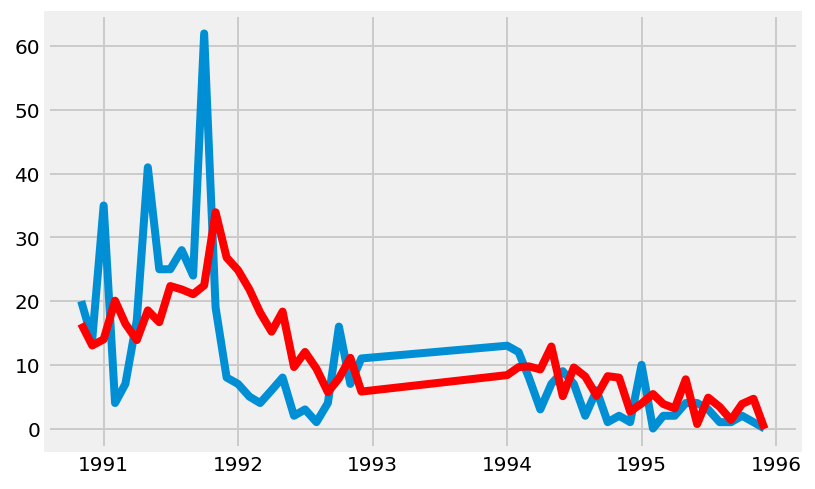

In [92]:
# putting predictions into pandas series
predictions = pd.Series(results2.fittedvalues, copy=True)

# plotting predictions 
plt.plot(df_bombings_by_region['Central America & Caribbean'].ix[250:300])
plt.plot(predictions.ix[250:300], color='red')

In [93]:
predictions.ix[250:300]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date/Time_of_attack
1990-11-01    16.446792
1990-12-01    13.040649
1991-01-01    13.993886
1991-02-01    20.064344
1991-03-01    16.443166
1991-04-01    13.881820
1991-05-01    18.539079
1991-06-01    16.690112
1991-07-01    22.361235
1991-08-01    21.828984
1991-09-01    21.081906
1991-10-01    22.461371
1991-11-01    33.945182
1991-12-01    26.835961
1992-01-01    24.858501
1992-02-01    21.813274
1992-03-01    18.204230
1992-04-01    15.199060
1992-05-01    18.355580
1992-06-01     9.650145
1992-07-01    12.019246
1992-08-01     9.393778
1992-09-01     5.708878
1992-10-01     7.875218
1992-11-01    11.098324
1992-12-01     5.797878
1994-01-01     8.385208
1994-02-01     9.637112
1994-03-01     9.751654
1994-04-01     9.278734
1994-05-01    12.877719
1994-06-01     5.076984
1994-07-01     9.582491
1994-08-01     8.164941
1994-09-01     5.134763
1994-10-01     8.216897
1994-11-01     7.981363
1994-12-01     2.682767
1995-01-01     3.933914
1995-02-01     5.413670
1995-03-01     3.854

### South America

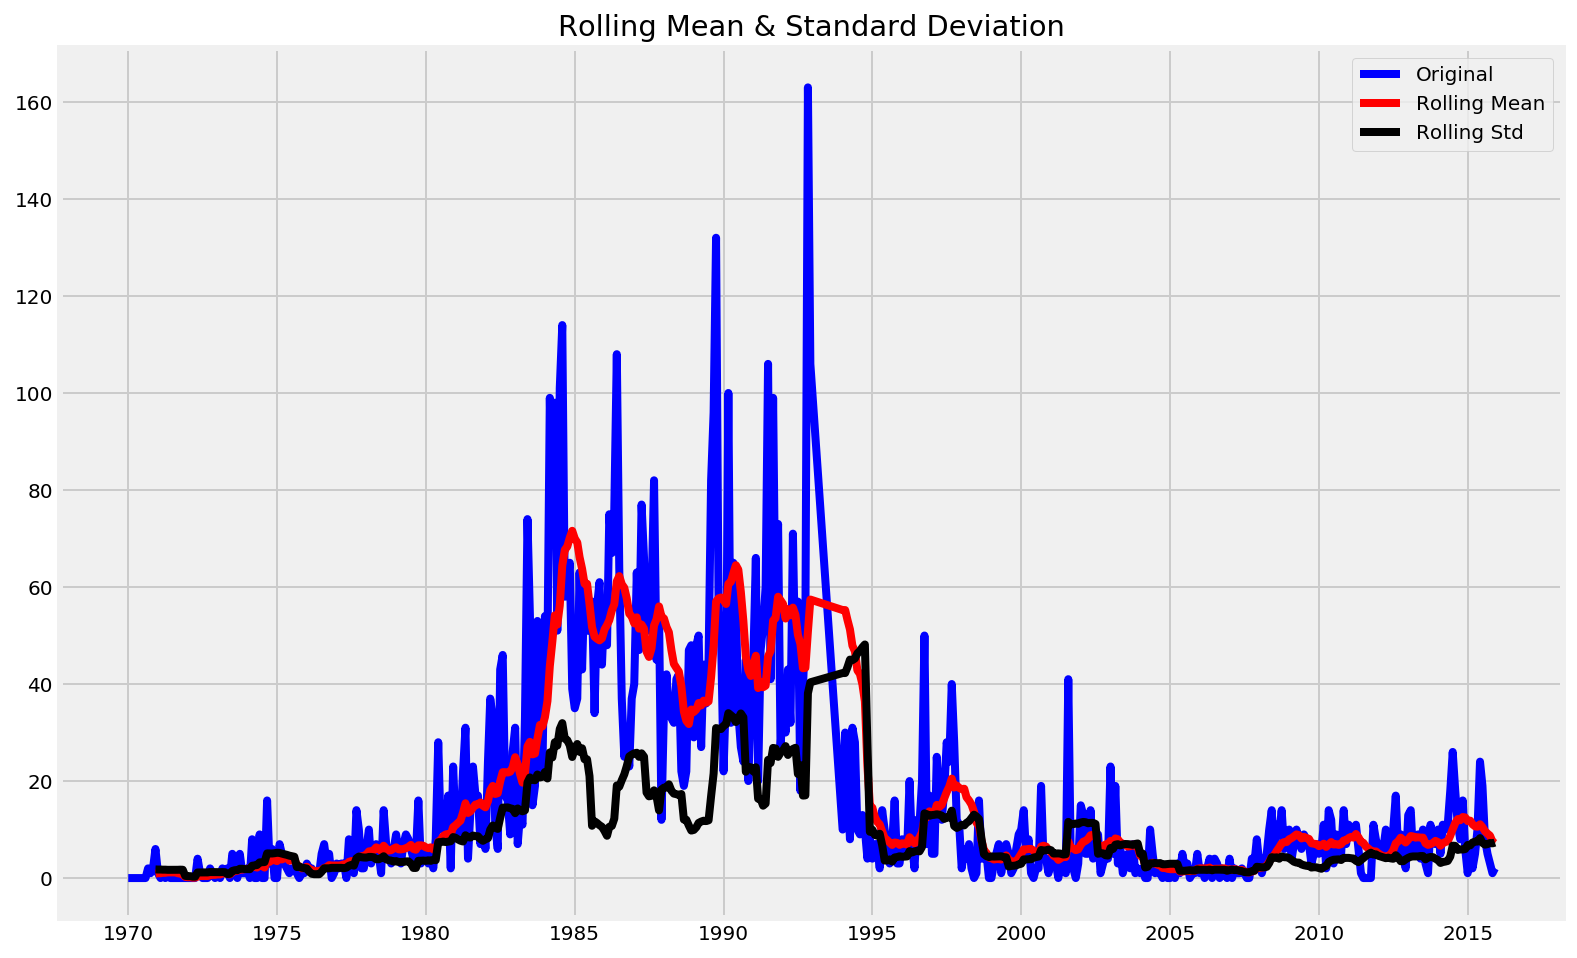

Results of Dickey-Fuller Test:
Test Statistic                  -1.809657
p-value                          0.375678
#Lags Used                      14.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


In [94]:
test_stationarity(df_bombings_by_region['South America'])

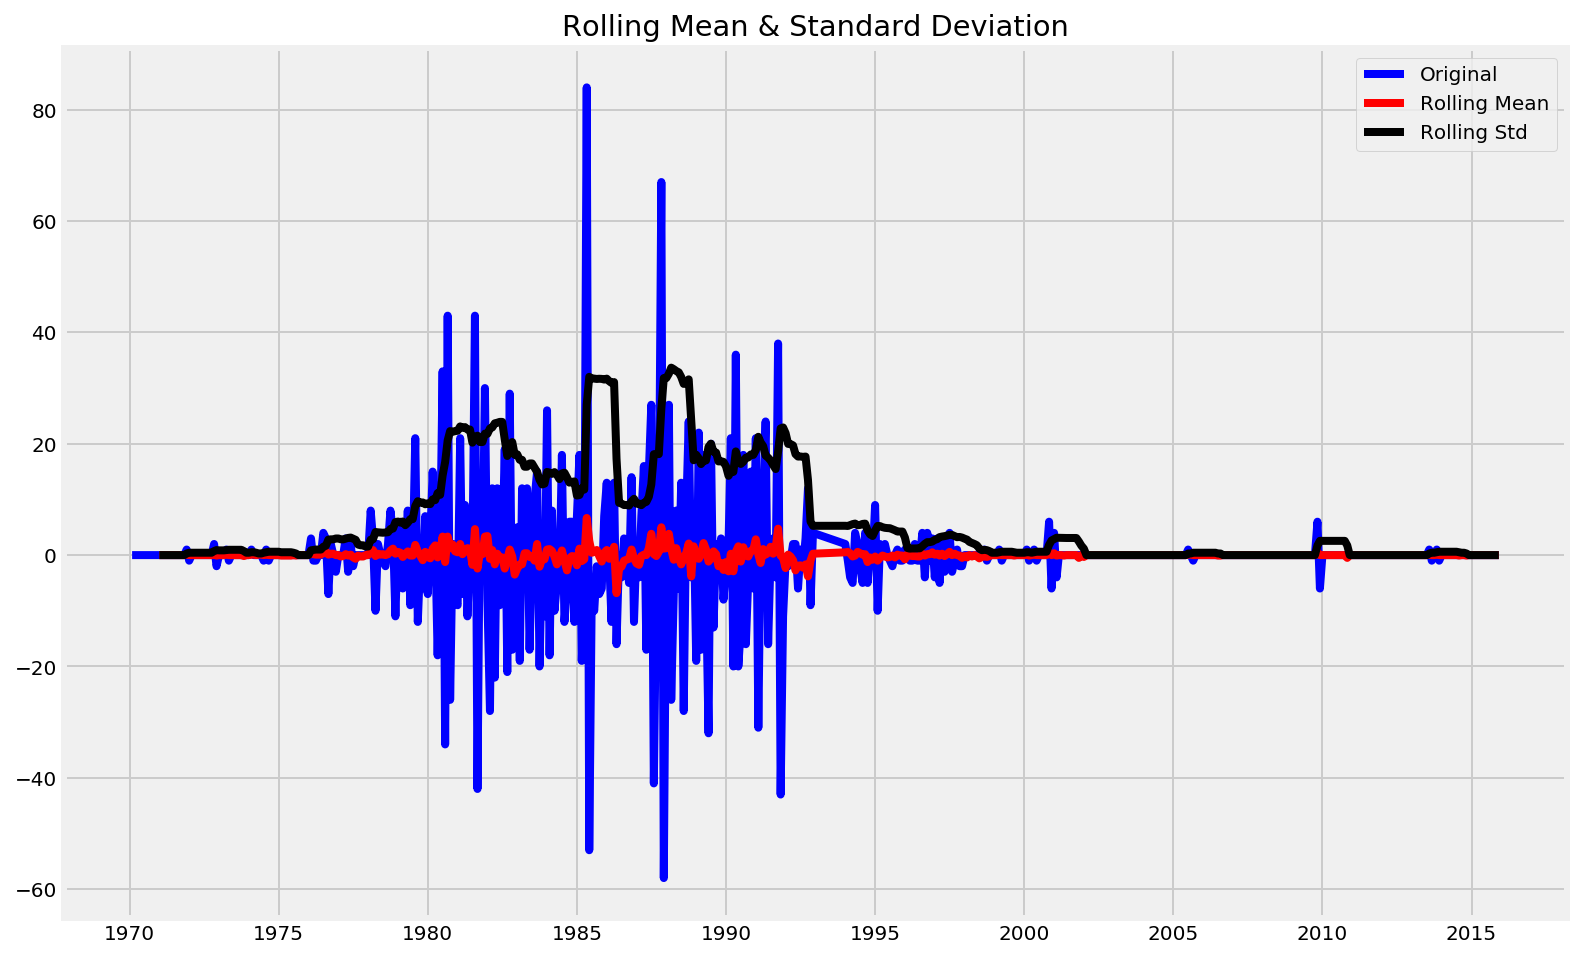

Results of Dickey-Fuller Test:
Test Statistic                -6.728809e+00
p-value                        3.336397e-09
#Lags Used                     1.700000e+01
Number of Observations Used    5.210000e+02
Critical Value (1%)           -3.442964e+00
Critical Value (5%)           -2.867103e+00
Critical Value (10%)          -2.569733e+00
dtype: float64


In [95]:
# Given that the above Test Statistic is greater than the 5% Critical Value, the data is not stationary. 
# testing the first difference for stationarity 
df_bombings_by_region['South_America_first_difference'] = df_bombings_by_region['South America'] - df_bombings_by_region['South America'].shift(1)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))

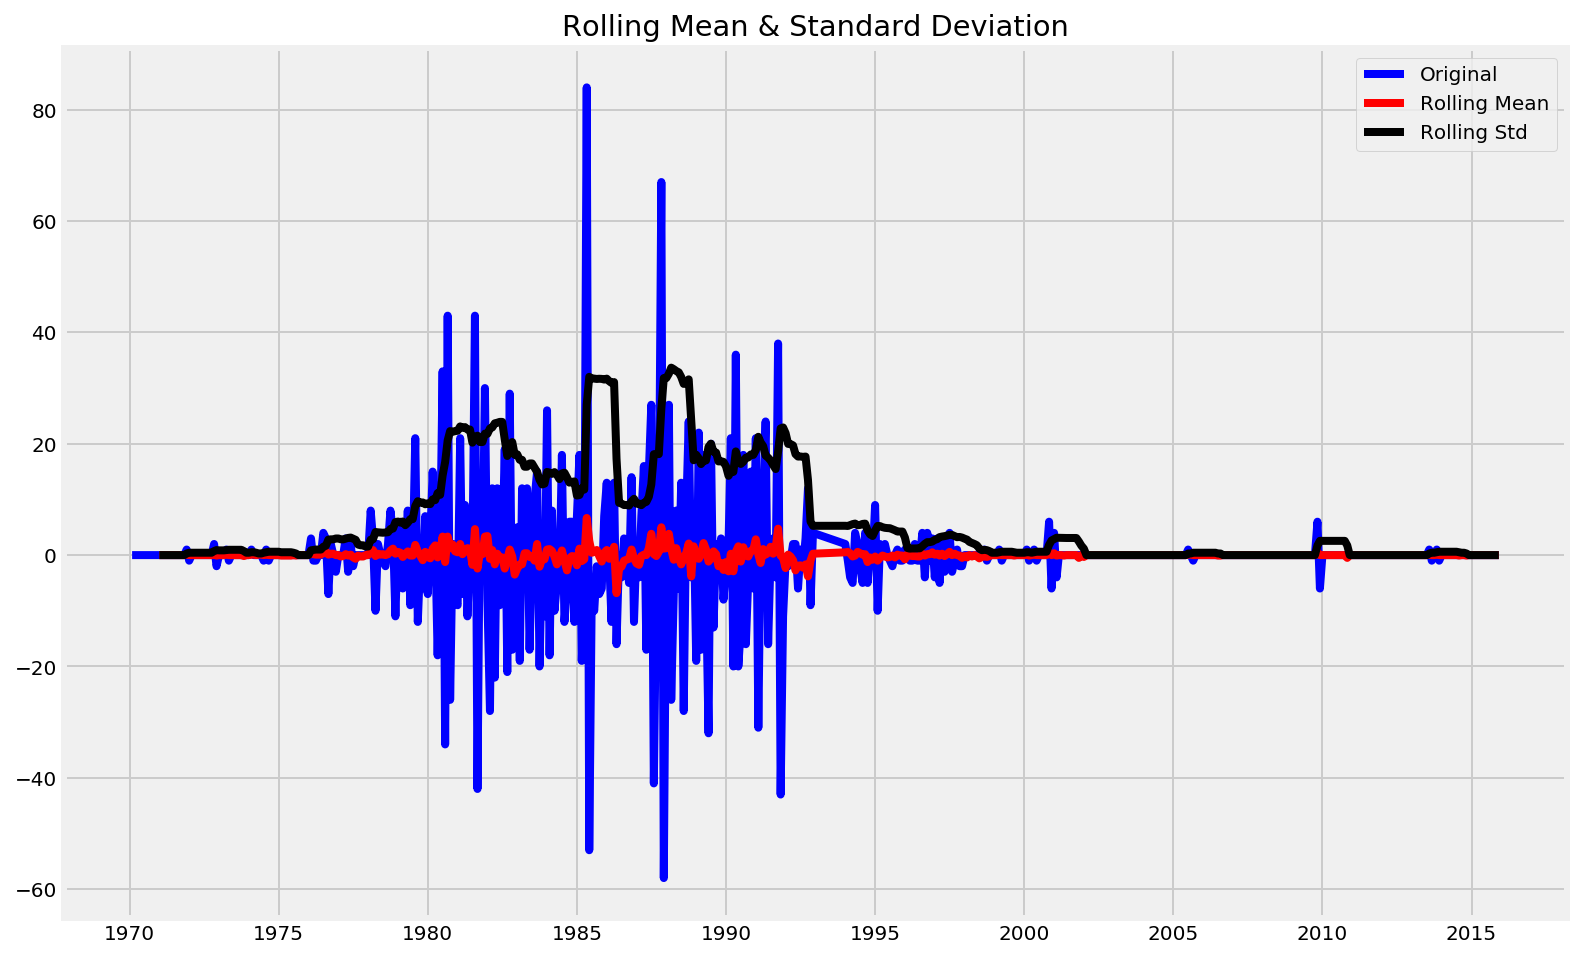

Results of Dickey-Fuller Test:
Test Statistic                -6.728809e+00
p-value                        3.336397e-09
#Lags Used                     1.700000e+01
Number of Observations Used    5.210000e+02
Critical Value (1%)           -3.442964e+00
Critical Value (5%)           -2.867103e+00
Critical Value (10%)          -2.569733e+00
dtype: float64


In [96]:
#Checking for seasonal stationarity
df_bombings_by_region['South_America_season_first_difference'] = df_bombings_by_region['South_America_first_difference'] - df_bombings_by_region['South_America_first_difference'].shift(12)  
test_stationarity(df_bombings_by_region.CA_Caribbean_first_difference.dropna(inplace=False))